## Content <a id='content'></a>

[Introduction](#intro)

[Datasets](#datasets)

[Data preprocessing](#prep)

[Data Analysis](#eda)

[Conclusions](#conclusions)

# Introduction <a id='intro'></a>

The task at hand is to help optimize marketing expenses for an app. We are going to study:

- How people use the product;
- When they start to buy and how much money each customer brings;
- Whether and when customers pay off.

Let's elaborate a bit what questions we should answer first.

**1. Product**

With regard to the product, we are usually interested in knowing the product usage statistics:  
- How many people use it every day, week, and month?
- How many sessions are there per day? (One user might have more than one session.)
- What is the length of each session?
- How often do users come back?

**2. Sales**

We are usually interested in knowing the time that elapses between registration and conversion — when the user becomes a customer. In addition, we should study the order statistics - number of orders per user, order volumes, lifetime value of customers to compare with the cost of customer acquisition later.  Thus, the questions we would like to finds answers to are:

- When do people start buying?
- How many orders do they make during a given period of time?
- What is the average purchase size?
- How much money do they bring? (LTV)

**3. Marketing**

In this part, we are interested to know how much money was invested in a particular marketing channel and what was its efficiency; thus, we will answer the following questions:

- How much money was spent? Overall/per source/over time
- How much did customer acquisition from each of the sources cost?
- How worthwhile where the investments? (ROI)

Along with performing the calculations, we will plot graphs to display how these metrics differ for various devices and ad sources and how they change in time.

Then, we will be able to derive a conclusion and advise marketing experts how much money to invest and where:

- What sources/platforms would you recommend?
- Back up your choice: what metrics did you focus on? Why?
- What conclusions did you draw after finding the metric values?

[Back to Content](#content)

# Datasets <a id='datasets'></a>

At our disposal we have:

1. `visits_log_us.csv` - Server logs with data on app visits from June 2017 through May 2018
2. `orders_log_us.csv` - Dump file with all orders for the period
3. `costs_us.csv` - Marketing expenses statistics

## Description of the data

The visits table (server logs with data on website visits):

- `Uid` — user's unique identifier
- `Device` — user's device
- `Start Ts` — session start date and time
- `End Ts` — session end date and time
- `Source Id` — identifier of the ad source the user came from

All dates in this table are in YYYY-MM-DD format.

The orders table (data on orders):

- `Uid` — unique identifier of the user making an order
- `Buy Ts` — order date and time
- `Revenue` — app's revenue from the order

The costs table (data on marketing expenses):

- `source_id` — ad source identifier
- `dt` — date
- `costs` — expenses on this ad source on this day

[Back to Content](#content)

# Data preprocessing <a id='prep'></a>

## Libraries

Let's load the libraries we might need:

In [1]:
# Loading the libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt # We will need this for visualisations
%matplotlib inline
import seaborn as sns

from scipy import stats # We will need this in case we want to make some statistical checks

# To filter out automatic comments on plots from Jupyter (not affecting the output)
import warnings
warnings.filterwarnings("ignore") 

## File upload with correct data types

Out of the three files, the `visits_log_us.csv` file seems to be the largest and requiring some optimization upon upload. Let's investigate it a bit.

We will use a `load()` function to avoid potential problems with the file pathes.

In [2]:
# function `load` for a csv load with try-except and a number of rows limit
def load(filename, nrows):
    """
    i=In addition to the file name, the function takes nrow parameter
    for a particular number of rows to load. If None, then the file is loaded fully.
    """
    try:
        df_raw = pd.read_csv(filename, nrows=nrows)
    except:
        df_raw = pd.read_csv('/'+filename, nrows=nrows)
    return df_raw

In [3]:
# Load the first 500 rows of the visits file into a DataFrame
visits_500 = load('datasets/visits_log_us.csv', 500)

In [4]:
visits_500.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
Device       500 non-null object
End Ts       500 non-null object
Source Id    500 non-null int64
Start Ts     500 non-null object
Uid          500 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB


The first 500 rows take 133 KB of the memory, let's get rid of the object type when possible.

In [5]:
visits_500['Device'].value_counts()

desktop    363
touch      137
Name: Device, dtype: int64

The `Device` column has only two values: desktop and touch; let's cast it into a  category variable:

In [6]:
visits_500['Device'] = visits_500['Device'].astype('category')
visits_500.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
Device       500 non-null category
End Ts       500 non-null object
Source Id    500 non-null int64
Start Ts     500 non-null object
Uid          500 non-null uint64
dtypes: category(1), int64(1), object(2), uint64(1)
memory usage: 82.8 KB


We've saved 50 KB out of 133 KB, 37.5%!

The columns `Start Ts` and `End Ts` contain the date and time, let's cast them to date with the `to_datetime()` method.

In [7]:
visits_500['Start Ts'] =  pd.to_datetime(visits_500['Start Ts'], format="%Y-%m-%d %H:%M:%S")
visits_500['End Ts'] =  pd.to_datetime(visits_500['End Ts'], format="%Y-%m-%d %H:%M:%S")
visits_500.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
Device       500 non-null category
End Ts       500 non-null datetime64[ns]
Source Id    500 non-null int64
Start Ts     500 non-null datetime64[ns]
Uid          500 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 16.4 KB


Now the `visits_500` dataset uses 12.4% of its initial memory requirement! Now we are ready to get the correct data types when we download data in the first place. Let's modify our `load()` function a bit:

In [8]:
# function `load` for a csv load with try-except, row number limit and dtype and parse_dates definitions.
def load(filename, nrows = None, dtype = None, parse_dates=None):
    """
    We add `dtype` and `parse_dates` parameters to pass to the `read_csv()` function.
    The function prints out `df.info()` and returns the dataset as pandas DataFrame.
    """
    try:
        df_raw = pd.read_csv(filename, nrows=nrows, dtype=dtype, parse_dates = parse_dates)
    except:
        df_raw = pd.read_csv('/'+filename, nrows=nrows, dtype=dtype, parse_dates = parse_dates)
    print(df_raw.info(memory_usage='deep'))
    return df_raw

In [9]:
# Load the full visits file into a DataFrame
visits = load(
            'datasets/visits_log_us.csv',
            dtype={'Device': 'category'},
            parse_dates=['Start Ts', 'End Ts'],
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null category
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
None


We have uploaded the visits file, let's add the orders and marketing costs files.

In [10]:
# Load the first 500 rows of the order file into a DataFrame
orders_500 = load(
            'datasets/orders_log_us.csv',
            nrows = 500,
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
Buy Ts     500 non-null object
Revenue    500 non-null float64
Uid        500 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 45.0 KB
None


In [11]:
# Load the first 500 rows of the marketing costs file into a DataFrame
costs_500 = load(
            'datasets/costs_us.csv',
            nrows = 500,
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
source_id    500 non-null int64
dt           500 non-null object
costs        500 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 40.7 KB
None


Both files have one column to cast:

In [12]:
# Load the order file into a DataFrame
orders = load(
            'datasets/orders_log_us.csv',
            parse_dates=['Buy Ts'],
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None


In [13]:
# Load the marketing costs file into a DataFrame
costs = load(
            'datasets/costs_us.csv',
            parse_dates=['dt'],
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB
None


[Back to Content](#content)

## Column name update

We have uploaded the files with correct data types, let's update the column names in the `visits` and `orders` dataframes to make them more usable. To this end, we will define `column_name_upd()` function:

In [14]:
def column_names_upd(df):
    """
    The function takes a dataframe and modifies its column names;
    it prints out the new column names and returns them as a list.
    """
    
    col_lst = df.columns.to_list()
    col_upd = []
    for name in col_lst:
        col_upd.append(("_").join(name.lower().split(" ")))
    print ("New dataframe column names are:", col_upd)
    return col_upd

In [15]:
visits.columns = column_names_upd(visits)

New dataframe column names are: ['device', 'end_ts', 'source_id', 'start_ts', 'uid']


In [16]:
orders.columns = column_names_upd(orders)

New dataframe column names are: ['buy_ts', 'revenue', 'uid']


[Back to Content](#content)

## Data overview <a id='data_overview'></a>

Let's take a look at the data itself.

In [17]:
visits.head(10)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Let's check the datetime columns ranges:

In [18]:
print("Visit start time range:", visits['start_ts'].min(), visits['start_ts'].max())
print("Visit end time range:",visits['end_ts'].min(), visits['end_ts'].max())

Visit start time range: 2017-06-01 00:01:00 2018-05-31 23:59:00
Visit end time range: 2017-06-01 00:02:00 2018-06-01 01:26:00


The first visit in the dataset started at 00 hour 01 min on June 01, 2017; the last visit started 1 min before midnight one year later; the last visit to end ended up at 01 hour 26 min on June 01, 2017.

It could be interesting to check whether there are visits of zero durations, but the data at hand are at minute resolution, thus every value under 60 seconds well result in zero duration. Let's take a look at the distribution anyway.

In [19]:
visits['duration_min'] = (visits['end_ts'] - visits['start_ts']).dt.seconds / 60

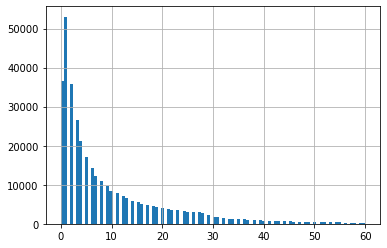

In [20]:
visits['duration_min'].hist(range = (0,60), bins = 100)
plt.show()

Let's check some stats for this column:

In [21]:
visits['duration_min'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: duration_min, dtype: float64

In [22]:
visits['duration_min'].mode()

0    1.0
dtype: float64

There are definetely some outliers, as well as ultra-short visits, and the distribution is in any case non-normal: the median duration is 5 minutes, while the average is above 10 minutes and the maximum duration is around 23.5 hours. The mode has a value of 1 minute. In what follows, we will investigate the distribution further on, including the possible differences by `device` category. Let's check out the orders.

In [23]:
orders.head(10)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


It can be interesting to make sure that we do not have duplicates there and check out the dates range:

In [24]:
orders.duplicated().sum()

0

In [25]:
print("Order time range:", orders['buy_ts'].min(), orders['buy_ts'].max())

Order time range: 2017-06-01 00:10:00 2018-06-01 00:02:00


The `orders` dataframe does not have duplicates; the first payment in the dataset was proceed at 10 minutes past midnight on June 01, 2017, while the last one at 02 minutes past midnight one year later. We will deep dive into it later on, let's check out the last one, `costs`.

In [26]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


It can be interesting to see how many sources we are dealing with.

In [27]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

We have seven marketing sources to analyze, interestingly for most of them there is data only for 363 days out of 365 for the year under consideration, and 364 for the category number `5`, which means that there are at least two days for that year for each category that we do not have marketing cost data:

In [28]:
costs.pivot_table(index = 'source_id', aggfunc = ['min', 'max', 'count'])

min                 max            count     
           costs         dt    costs         dt costs   dt
source_id                                                 
1           5.80 2017-06-01   245.75 2018-05-31   363  363
2          15.08 2017-06-01   507.09 2018-05-31   363  363
3          39.26 2017-06-01  1788.28 2018-05-31   363  363
4           0.83 2017-06-01   788.03 2018-05-31   363  363
5           0.70 2017-06-01   719.22 2018-05-31   364  364
9           1.85 2017-06-01    49.53 2018-05-31   363  363
10          0.54 2017-06-01    68.11 2018-05-31   363  363

### Summary on datasets

1. A quick check of the necessary data types was performed before the upload, to make the memory usage more effective.
2. The resulting datasets contain data on 359400 visits, 50415 orders and 2542 data points of expenses on different marketing sources.
3. No missing values, some column names required fixing.
4. The first visit in the dataset started at 00 hour 01 min on June 01, 2017; the last visit started 1 min before midnight one year later; the last visit to end ended up at 01 hour 26 min on June 01, 2017.
5. There are definetely some outliers, as well as ultra-short visits, and the distribution is in any case non-normal: the median duration is 5 minutes, while the average is above 10 minutes and the maximum duration is around 23.5 hours. The mode has a value of 1 minute.
6. The `orders` dataframe does not have duplicates; the first payment in the dataset was proceed at 10 minutes past midnight on June 01, 2017, while the last one at 02 minutes past midnight one year later.
7. We have seven marketing sources to analyze, interestingly for most of them there is data only for 363 days out of 365 for the year under consideration, and 364 for the category number `5`.

[Back to Content](#content)

# Data Analysis <a id='eda'></a>

## Product

With regard to the product, we are interested in knowing the product usage statistics:  
- How many people use it every day, week, and month?
- How many sessions are there per day?
- What is the length of each session?
- How often do users come back?

### How many people use it every day, week, and month?

To answer the first question, we need to calculate The three main metrics that describe the number of active users:

- DAU — the number of daily active (unique) users;
- WAU — the number of weekly active users;
- MAU — the number of monthly active users.

Let's recap on how the `visits` dataframe looks like:

In [29]:
visits.head()

,device,end_ts,source_id,start_ts,uid,duration_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0.0



We'll first create separate columns for year, month, and week values.

In [30]:
visits['visit_year']  = visits['start_ts'].dt.year
visits['visit_month'] = visits['start_ts'].dt.month
visits['visit_week']  = visits['start_ts'].dt.week
visits['visit_date'] = visits['start_ts'].dt.date

In [31]:
visits.head()

,device,end_ts,source_id,start_ts,uid,duration_min,visit_year,visit_month,visit_week,visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18.0,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28.0,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0.0,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24.0,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0.0,2017,12,52,2017-12-27


Now let's calculate the metrics:

In [32]:
dau_total = visits.groupby('visit_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['visit_year', 'visit_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['visit_year', 'visit_month']).agg({'uid': 'nunique'}).mean()

In [33]:
active_users = {}

In [34]:
active_users['total'] = [int(dau_total), int(wau_total), int(mau_total)]
active_users

{'total': [907, 5716, 23228]}

**Thus, the answer to the first question is as follows: the average number of people using the app every day is 907; on the weekly basis 5716 people on average use the app; on the monthly basis the average number of users is 23228.**

Let's add  resolution and calculate how many users there are for each type of device. We will build three lists: users which use only desktop devices, those who use only touch devices, and those who use both.

In [35]:
# Define subsets of users who use desktops and those who use touch devices
visits_desk = visits[visits['device']=='desktop']
visits_touch = visits[visits['device']=='touch']

In [36]:
# all users who used desktop
desk_users = visits_desk['uid'].unique()
# all users who used touch device
touch_users = visits_touch['uid'].unique()

desk_users = pd.DataFrame(desk_users, columns = ['uid'])
desk_users['desktop'] = 1
desk_users = desk_users.set_index('uid')

touch_users = pd.DataFrame(touch_users, columns = ['uid'])
touch_users['touch'] = 1
touch_users = touch_users.set_index('uid')

In [37]:
users_device = desk_users.join(touch_users, how = 'outer')

In [38]:
users_device.head()

,desktop,touch
uid,,
11863502262781,NaN,1.0
49537067089222,NaN,1.0
297729379853735,1.0,NaN
313578113262317,1.0,NaN
325320750514679,1.0,NaN


In [39]:
# tagging users who used desktop, touch, or both
users_device.fillna(0, inplace = True)
users_device['both'] = users_device['desktop'] + users_device['touch']
users_device = users_device.astype('int64')
users_device.head()

,desktop,touch,both
uid,,,
11863502262781,0,1,1
49537067089222,0,1,1
297729379853735,1,0,1
313578113262317,1,0,1
325320750514679,1,0,1


In [40]:
only_desk_users = users_device[~(users_device['desktop'] == True) & (users_device['touch']==True)].index.to_list()
only_touch_users = users_device[(users_device['desktop'] == True) & ~(users_device['touch']==True)].index.to_list()
two_device_users = users_device[(users_device['desktop'] == True) & (users_device['touch']==True)].index.to_list()

In [41]:
users_dict = {}
users_dict['total'] = visits['uid'].unique()
users_dict['desktop'] = only_desk_users
users_dict['touch'] = only_touch_users
users_dict['two'] = two_device_users

Let's check the sums:

In [42]:
len(users_dict['total'])

228169

In [43]:
print(f"Total users - {visits['uid'].nunique()}; only desktop users - {len(users_dict['desktop'])}; \
only touch users - {len(users_dict['touch'])}; two device users - {len(users_dict['two'])}.")

Total users - 228169; only desktop users - 63646; only touch users - 156824; two device users - 7699.


Let's calculate **DAU**, **WAU**, and **MAU** of this three groups. We will define a dictionary to store the series themselves and will update the previously defined `active_users` dictionary for storing the resulting means of the `dau`, `wau`, and `mau` values.

In [44]:
dau_series_dict = {}
wau_series_dict = {}
mau_series_dict = {}
for key in users_dict:
    lst = users_dict[key]
    dau_series = visits.query('uid in @lst').groupby(['visit_date']).agg({'uid': 'nunique'}).reset_index()
    wau_series = visits.query('uid in @lst').groupby(['visit_year',
                                                      'visit_week']).agg({'visit_date': 'min',
                                                                          'uid': 'nunique'}).reset_index()
    mau_series = visits.query('uid in @lst').groupby(['visit_year',
                                                      'visit_month']).agg({'visit_date': 'min',
                                                                           'uid': 'nunique'}).reset_index()
    dau = dau_series['uid'].mean()
    wau = wau_series['uid'].mean()
    mau = mau_series['uid'].mean()
    # Update dictionaries
    active_users[key] = [int(dau), int(wau), int(mau)]
    dau_series_dict[key] = dau_series
    wau_series_dict[key] = wau_series
    mau_series_dict[key] = mau_series

In [45]:
active_users_df = pd.DataFrame.from_dict(active_users)
active_users_df['metric'] = ['dau', 'wau', 'mau']
active_users_df = active_users_df.set_index('metric')
active_users_df

,total,desktop,touch,two
metric,,,,
dau,907,216,608,83
wau,5716,1414,3845,456
mau,23228,5956,15699,1572


**Thus, most users use the product using touch devices: the daily average of peole using the app from a touch device only is 557 out of 907 daily active users; there are users using the app both from a desktop and from a touch device, their share veries from ~8% of all daily active users to ~6% of all monthly active users.**

Note, that when counting user visits by user device groups, there are less unique active users per day, week, or month than when counting without any reference to the device type used. One possible explanation is that users who use both desktop and touch devices use them in different days, thus showing up as more active  on the daily basis if we count them whith no reference to the device type.

Let's see how DAU graphs look for different user categories.

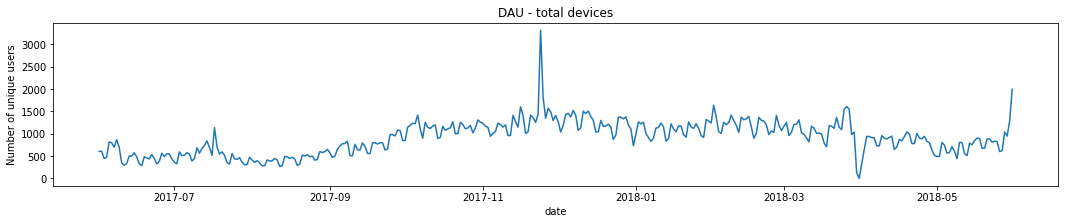

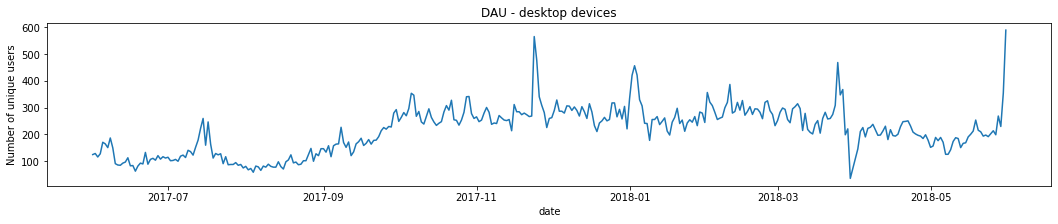

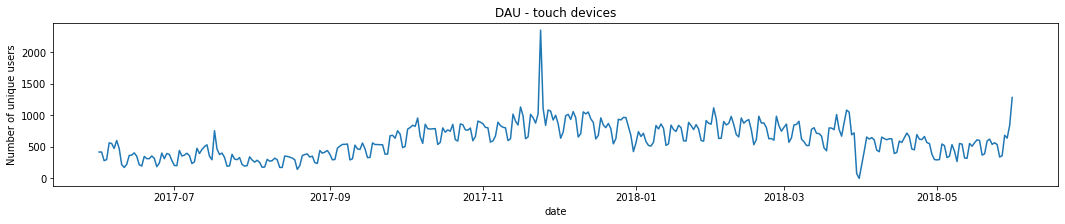

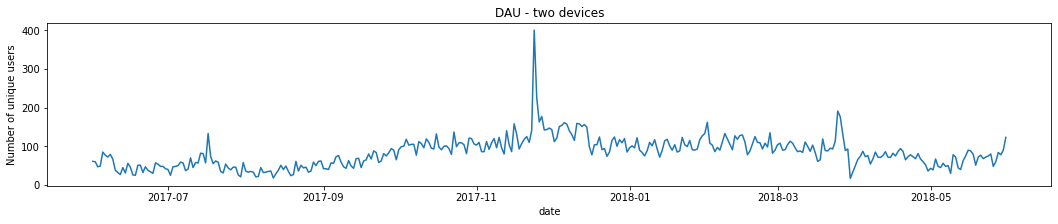

In [46]:
for key in dau_series_dict:
    df = pd.DataFrame(dau_series_dict[key])
    df['visit_date'] = pd.to_datetime(df['visit_date'])
    plt.figure(figsize=(18, 3))
    sns.lineplot(y = 'uid', x = 'visit_date', data = df, ci = 'sd')
    plt.xlabel("date")
    plt.ylabel("Number of unique users")
    plt.title(f"DAU - {key} devices")
    plt.show()

The patterns of user activities look slightly different for desktop users and users of either touch devices or both. Since the majority of the users are using touch devices, the difference does not affect much the DAU in total. Thus, for the following comparison we can use metrics with no regard to categories. Let's compare DAU, WAU, and MAU by months.

Let's recap how the dau metrics look like.

In [47]:
print(dau_series_dict['total'].head())

  visit_date  uid
0 2017-06-01  605
1 2017-06-02  608
2 2017-06-03  445
3 2017-06-04  476
4 2017-06-05  820


Since we are interested in month-by-month comparison, we will have to find the average values by months for both `dau_series` and `wau_series`.

In [48]:
dau_df = pd.DataFrame(dau_series_dict['total'])
dau_df['visit_date'] = pd.to_datetime(dau_df['visit_date'])
dau_df['visit_month'] = dau_df['visit_date'].dt.strftime('%Y-%m').astype('str')

In [49]:
dau_monthly_average = dau_df.groupby('visit_month').agg({'uid': 'mean'}).astype('int')

In [50]:
dau_monthly_average.columns = ['dau_avg']

In [51]:
wau_df = pd.DataFrame(wau_series_dict['total'])
wau_df['visit_date'] = pd.to_datetime(wau_df['visit_date'])
wau_df['visit_month'] = wau_df['visit_date'].dt.strftime('%Y-%m').astype('str')

In [52]:
wau_monthly_average = wau_df.groupby('visit_month').agg({'uid': 'mean'}).astype('int')

In [53]:
wau_monthly_average.columns = ['wau_avg']

In [54]:
mau_df = pd.DataFrame(mau_series_dict['total'])
mau_df['visit_date'] = pd.to_datetime(mau_df['visit_date'])
mau_df['visit_month'] = mau_df['visit_date'].dt.strftime('%Y-%m').astype('str')
mau_ = mau_df[['visit_month', 'uid']]
mau_ = mau_.set_index('visit_month')
mau_.columns = ['mau']

Now we can join the resulting series and put them on one graph.

In [55]:
monthly_au_metrics = dau_monthly_average.join(wau_monthly_average).join(mau_)

In [56]:
monthly_au_metrics.head(1)

,dau_avg,wau_avg,mau
visit_month,,,
2017-06,510,2980,13259


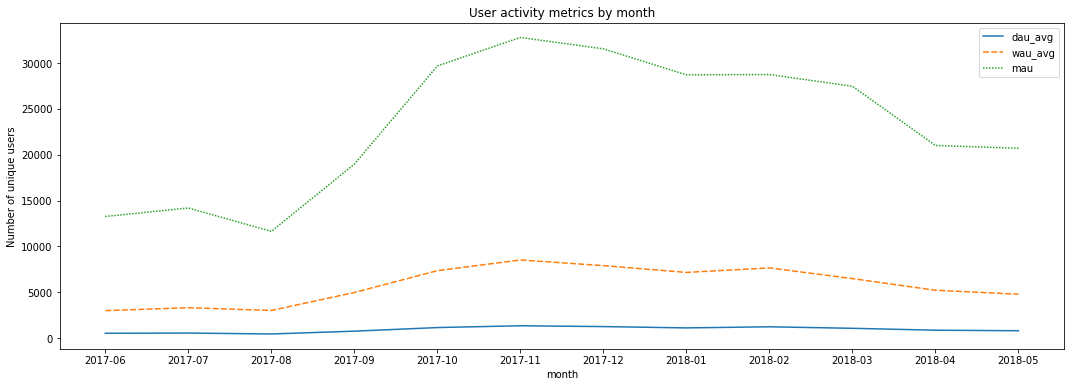

In [57]:
plt.figure(figsize=(18, 6))
sns.lineplot(data = monthly_au_metrics)
plt.xlabel("month")
plt.ylabel("Number of unique users")
plt.title(f"User activity metrics by month")
plt.show()

[Back to Content](#content)

### How many sessions are there per day?

Let's add  resolution and calculate how many visits the users perform per day and from which type of device.

In [58]:
visit_num = {}

In [59]:
for key in active_users:
    lst = users_dict[key]
    d_visits = visits.query('uid in @lst').groupby(['visit_date']).agg({'uid': 'count'}).mean()
    d_visits = int(d_visits)
    w_visits = visits.query('uid in @lst').groupby(['visit_year', 'visit_week']).agg({'uid': 'count'}).mean()
    w_visits = int(w_visits)
    m_visits = visits.query('uid in @lst').groupby(['visit_year', 'visit_month']).agg({'uid': 'count'}).mean()
    m_visits = int(m_visits)
    visit_num[key] = [d_visits, w_visits, m_visits]

In [60]:
visit_num_df = pd.DataFrame.from_dict(visit_num)
visit_num_df['metric'] = ['daily_visits',
                          'weekly_visits',
                          'monthly_visits']
visit_num_df = visit_num_df.set_index('metric')
visit_num_df

,total,desktop,touch,two
metric,,,,
daily_visits,987,227,661,98
weekly_visits,6781,1558,4545,676
monthly_visits,29950,6884,20078,2987


**Thus, there are on average 987 sessions on the daily basis, 6781 visit on the weekly basis and 29950 on the monthly basis for the period of time under consideration. We will use the number of visits by different groups of users to reveal any possible differences in the sessions per user numbers for these groups. Let's calculate the average number of visits.**

In [61]:
avg_visit_num = {}

In [62]:
for key in active_users:
    lst = users_dict[key]
    dau = active_users[key][0]
    wau = active_users[key][1]
    mau = active_users[key][2]
    d_visits = visits.query('uid in @lst').groupby(['visit_date']).agg({'uid': 'count'}).mean()
    d_visits = int(d_visits) / dau
    w_visits = visits.query('uid in @lst').groupby(['visit_year', 'visit_week']).agg({'uid': 'count'}).mean()
    w_visits = int(w_visits) / wau
    m_visits = visits.query('uid in @lst').groupby(['visit_year', 'visit_month']).agg({'uid': 'count'}).mean()
    m_visits = int(m_visits) / mau
    avg_visit_num[key] = [round(d_visits,2), round(w_visits,2), round(m_visits,2)]

In [63]:
avg_visit_num_df = pd.DataFrame.from_dict(avg_visit_num)
avg_visit_num_df['metric'] = ['daily_active_users_visits',
                          'weekly_active_users_visits',
                          'monthly_active_users_visits']
avg_visit_num_df = avg_visit_num_df.set_index('metric')
avg_visit_num_df

,total,desktop,touch,two
metric,,,,
daily_active_users_visits,1.09,1.05,1.09,1.18
weekly_active_users_visits,1.19,1.10,1.18,1.48
monthly_active_users_visits,1.29,1.16,1.28,1.90


**Thus, the average number of sessions per day equals 1.09, while users who use only desktop devices tend to make less visits and users who visit the app from either a touch device or from a desktop tend to perform 1.17 sessions per day on average. The same trend can be seen for weekly and monthly visits, while on the monthly basis the difference between the average number of sessions for monthly active users in total and the average number of visits for monthly active users using both types of devices becomes the most obvious.**

Let's add a graph showing month-by-month comparison of the number of visits.

In [64]:
dv_df = visits.groupby(['visit_date']).agg({'uid': 'count'}).reset_index()

wv_df = visits.groupby(['visit_year', 'visit_week']).agg({'visit_date': 'min',
                                                                'uid': 'count'}).reset_index()
mv_df = visits.groupby(['visit_year', 'visit_month']).agg({'visit_date': 'min',
                                                                'uid': 'count'}).reset_index()

To calculate the average of daily visits per user, we will merge `dv_df` with `dau_df`, calculate daily visits per unique user and derive averages:

In [65]:
dv_df['visit_date'] = pd.to_datetime(dv_df['visit_date'])

In [66]:
d_visit_stats = dau_df[['uid', 'visit_date']].merge(dv_df, on = 'visit_date')

In [67]:
d_visit_stats['visit_month'] = d_visit_stats['visit_date'].dt.strftime('%Y-%m').astype('str')

In [68]:
d_visit_stats['dayily_visits_per_user'] = d_visit_stats['uid_y'] / d_visit_stats['uid_x']

In [69]:
d_visit_stats.head(1)

,uid_x,visit_date,uid_y,visit_month,dayily_visits_per_user
0,605,2017-06-01,664,2017-06,1.097521


In [70]:
dv_monthly_average = d_visit_stats.groupby('visit_month').agg({'dayily_visits_per_user': 'mean'})

In [71]:
dv_monthly_average.columns = ['daily_visits_avg']

In [72]:
dv_monthly_average.head(2)

,daily_visits_avg
visit_month,
2017-06,1.073938
2017-07,1.077657


Great, now we will do the same for weekly stats: 

In [73]:
wv_df['visit_date'] = pd.to_datetime(wv_df['visit_date'])
w_visit_stats = wau_df[['uid', 'visit_date']].merge(wv_df, on = 'visit_date')
w_visit_stats['visit_month'] = w_visit_stats['visit_date'].dt.strftime('%Y-%m').astype('str')
w_visit_stats['weekly_visits_per_user'] = w_visit_stats['uid_y'] / w_visit_stats['uid_x']
wv_monthly_average = w_visit_stats.groupby('visit_month').agg({'weekly_visits_per_user': 'mean'})
wv_monthly_average.columns = ['weekly_visits_avg']

In [74]:
wv_monthly_average.head(2)

,weekly_visits_avg
visit_month,
2017-06,1.152763
2017-07,1.166961


And a similar calculation for monthly visits:

In [75]:
mv_df['visit_date'] = pd.to_datetime(mv_df['visit_date'])
m_visit_stats = mau_df[['uid', 'visit_date']].merge(mv_df, on = 'visit_date')
m_visit_stats['visit_month'] = m_visit_stats['visit_date'].dt.strftime('%Y-%m').astype('str')
m_visit_stats['monthly_visits_per_user'] = m_visit_stats['uid_y'] / m_visit_stats['uid_x']
mv_monthly_ = m_visit_stats[['visit_month', 'monthly_visits_per_user']]
mv_monthly_ = mv_monthly_.set_index('visit_month')

Now we can join the resulting series and put them on one graph.

In [76]:
monthly_visits_metrics = dv_monthly_average.join(wv_monthly_average).join(mv_monthly_)

In [77]:
monthly_visits_metrics.head(1)

,daily_visits_avg,weekly_visits_avg,monthly_visits_per_user
visit_month,,,
2017-06,1.073938,1.152763,1.244815


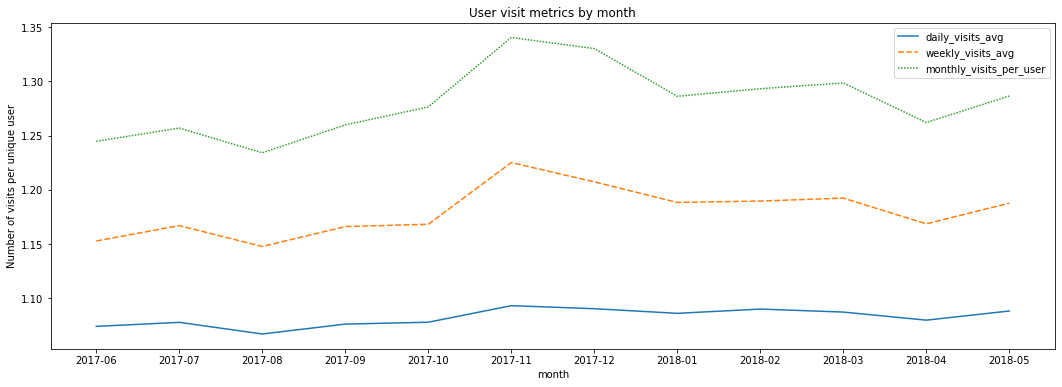

In [78]:
plt.figure(figsize=(18, 6))
sns.lineplot(data = monthly_visits_metrics)
plt.xlabel("month")
plt.ylabel("Number of visits per unique user")
plt.title(f"User visit metrics by month")
plt.show()

[Back to Content](#content)

### What is the length of each session?

Average session length, or ASL, is the amount of time users spend with a product in the average session. We remember that our timestamps are minute-wise and we [have already calculated visit duration](#data_overview) for the `visits` dataframe and taken a look at its distribution. Let's recap:

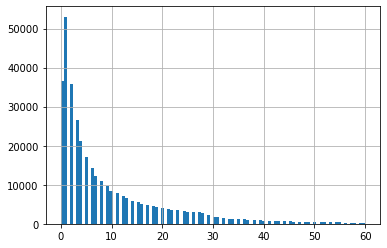

In [79]:
visits['duration_min'].hist(range = (0,60), bins = 100)
plt.show()

In [80]:
visits['duration_min'].describe()

count    359400.000000
mean         10.725108
std          16.938913
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: duration_min, dtype: float64

Since the distribution is non-normal, we have to use the mode as a proxy to ASL:

In [81]:
visits['duration_min'].mode()

0    1.0
dtype: float64

Let's compare ASL for different groups of user. Since, chances are the mode will remain of the same value, we will check the mean and the median values as well:

In [82]:
asl = {}
func_list = ['mode', 'median', 'mean', 'max']

In [83]:
for key in active_users:
    lst = users_dict[key]
    asl[key] = []
    df = visits.query('uid in @lst')
    for func in func_list:
        asl_ = df['duration_min'].apply(func)
        asl[key].append(int(asl_))

In [84]:
asl_df = pd.DataFrame.from_dict(asl)
asl_index = []
for func in func_list:
    asl_index.append("session_"+str(func)+"_dur")
asl_df['metric'] = asl_index
asl_df = asl_df.set_index('metric')
asl_df

,total,desktop,touch,two
metric,,,,
session_mode_dur,1,1,1,1
session_median_dur,5,3,5,6
session_mean_dur,10,7,11,12
session_max_dur,1408,372,1408,514


**The most frequent duration is one min and below for all users, desktop sessions tend to be shorter: 50 % of sessions last up to 3 minutes on a desktop and up to 5 min on a touch device, while users who use both type of devices tend to spent additional minute on the app. A side note (based on the max session duration), on touch devides the app can spend x3 time more than on desktops being active in the background mode.**

[Back to Content](#content)

### How often do users come back?

To answer this question, we have to employ cohort analysis.

Let's assign to each visit the date of the first session:

In [85]:
first_visit_date_by_users = visits.groupby('uid')['start_ts'].min()

In [86]:
first_visit_date_by_users.name = 'first_visit_date'

We use `join()` method to join the visits dataframe with the Series `first_visit_date_by_user` on the 'uid' column:

In [87]:
visits = visits.join(first_visit_date_by_users, on='uid')

In [88]:
visits.head(5)

,device,end_ts,source_id,start_ts,uid,duration_min,visit_year,visit_month,visit_week,visit_date,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18.0,2017,12,51,2017-12-20,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28.0,2018,2,8,2018-02-19,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0.0,2017,7,26,2017-07-01,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,24.0,2018,5,20,2018-05-20,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0.0,2017,12,52,2017-12-27,2017-12-27 14:06:00


The next step will be singling out months from the columns `first_visit_date` to form cohorts. Let's call the `astype()` method and convert the column values to the `'datetime64[M]'` type. Note: we already have `visit_month`, but for the purpose of the further analysis we will convert it to the the `'datetime64[M]'` type as well.

In [89]:
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

Let's add user lifetime within the cohort for each row of the initial dataframe: 

In [90]:
visits['cohort_lifetime'] = (visits['visit_month'] - visits['first_visit_month'])
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = round(visits['cohort_lifetime']).astype('int')
# visits.head()

In [91]:
#visits[(visits['first_visit_month']=='2018-04-01') & (visits['cohort_lifetime']!=0)]

Let's cast the month columns into string labels to simplify preparing the visualisation code later on.

In [92]:
visits['first_visit_month'] = visits['first_visit_month'].dt.strftime('%Y-%m').astype('str')
visits['visit_month'] = visits['visit_month'].dt.strftime('%Y-%m').astype('str')

Let's group the data by `first_visit_column` and evaluate the number of unique users for each cohort:

In [93]:
def visits_pivot(df, index = 'first_visit_month', columns = 'visit_month'):
    """
    The function takes a dataframe, an index ('first_visit_month' by default)
    and a column to pivot on ('visit_month' by default) and returns corresponding pivot table.
    """
    return df.pivot_table(
    index=index,
    columns=columns,
    values='uid',
    aggfunc='nunique',
    )

In [94]:
visits_pivot(visits)

visit_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_visit_month,,,,,,,,,,,,
2017-06,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07,NaN,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2017-08,NaN,NaN,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
2017-09,NaN,NaN,NaN,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
2017-10,NaN,NaN,NaN,NaN,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0
2017-11,NaN,NaN,NaN,NaN,NaN,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
2017-12,NaN,NaN,NaN,NaN,NaN,NaN,25268.0,1410.0,960.0,786.0,512.0,481.0
2018-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22624.0,1351.0,890.0,565.0,458.0
2018-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22197.0,1267.0,565.0,446.0


Let's visualize:

In [95]:
def cohort_viz(df, fmt = '.0f', title = 'Unique users by cohort',
               xlabel = "Visit month", ylabel = "First visit month", vmin = None, vmax = None):
    """
    A function which takes a cohort pivot table df and visualizes it as a heatmap.
    For more flexibility, it can take a rounding parameter fmt, and a title string.
    """
    plt.figure(figsize=(18, 6))
    plt.title(title)
    sns.heatmap(
        data = df, cmap="YlGnBu",
        annot=True,
        fmt=fmt,
        linewidths=2,
        linecolor='lightgray',
        vmin = vmin,
        vmax = vmax
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

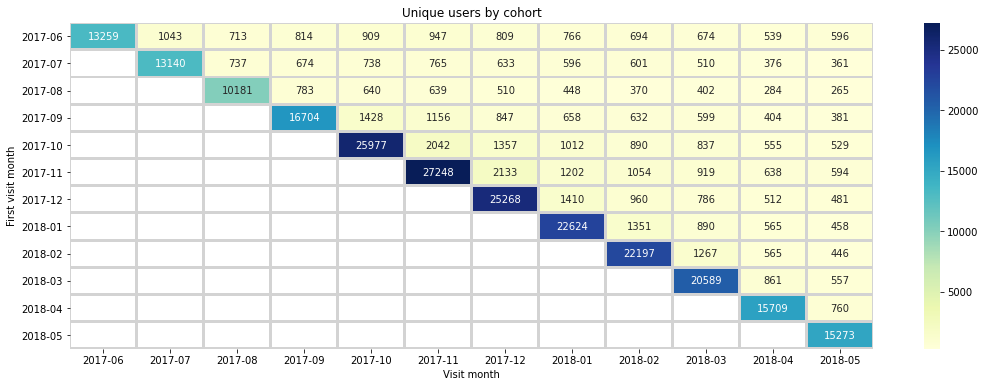

In [96]:
cohort_viz(visits_pivot(visits))

**The result shows that less than 8% of the users return to use the up even the month following the month of the first visit and by the end of the period under consideration the things got even worse: only about 4.8% of the first time user returned the month after. Note: in autumn and winter the app attracted more users, we will see later whether it is the consequency of higher marketing spendings.**

Let's try to see whether there is any difference between the desktop and the touch subgroups of users.

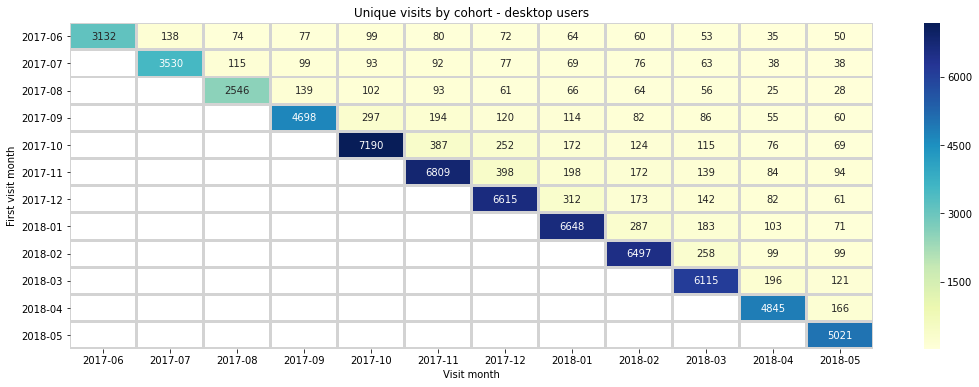

In [97]:
title = "Unique visits by cohort - desktop users"
cohort_viz(visits_pivot(visits.query('uid in @only_desk_users')), title = title)

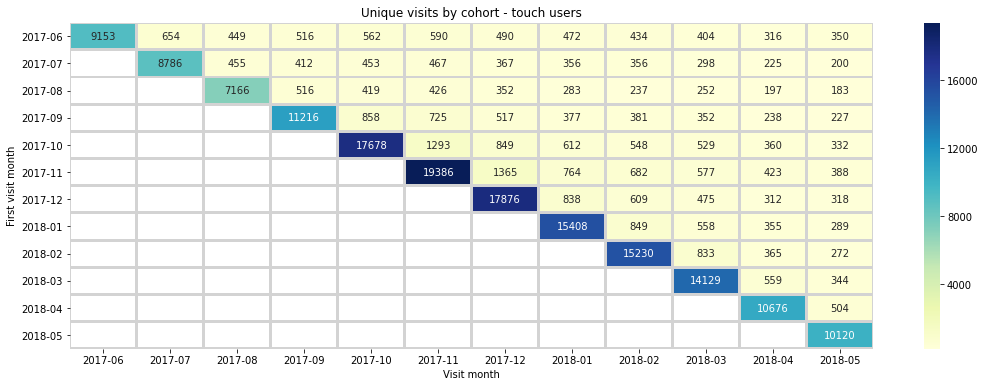

In [98]:
title = "Unique visits by cohort - touch users"
cohort_viz(visits_pivot(visits.query('uid in @only_touch_users')), title = title)

**Things are even worse for those users who use only desktop, compared to those who use only touch devices.**

Let's check out how those users who used both desktops and touch devices:

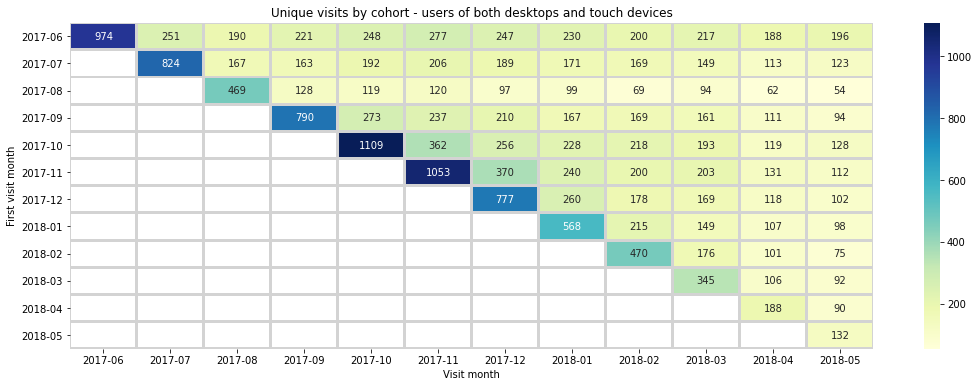

In [99]:
title = "Unique visits by cohort - users of both desktops and touch devices"
cohort_viz(visits_pivot(visits.query('uid in @two_device_users')), title = title)

**OK, those who use both desktops and touch devices are really different: their retention is much higher. However, anyway, they churn in general. Although in the first two cohorts, from June and July 2017, the number of active users increased for some short time in the autumn 2017, it did not change much for the rest of the cohorts. Users from the June 2017 cohort turned the most loyal though.**

Let's calculate the churn rates to get better understanding of the phenomenon. We will do this for the full dataset and in multiply the percentage change by 100 to make the visualization more friendly.

In [100]:
cohorts = visits.groupby(['first_visit_month', 'visit_month']).agg({'uid': 'nunique'}).reset_index()

In [101]:
# Apply pct_change() to find the percentage change in a column compared with the value in the previous row 
cohorts['churn_rate'] = cohorts.groupby(['first_visit_month'])['uid'].pct_change()*100 

In [102]:
churn_pivot = cohorts.pivot_table(
    index='first_visit_month',
    columns='visit_month',
    values='churn_rate',
    aggfunc='sum',
)


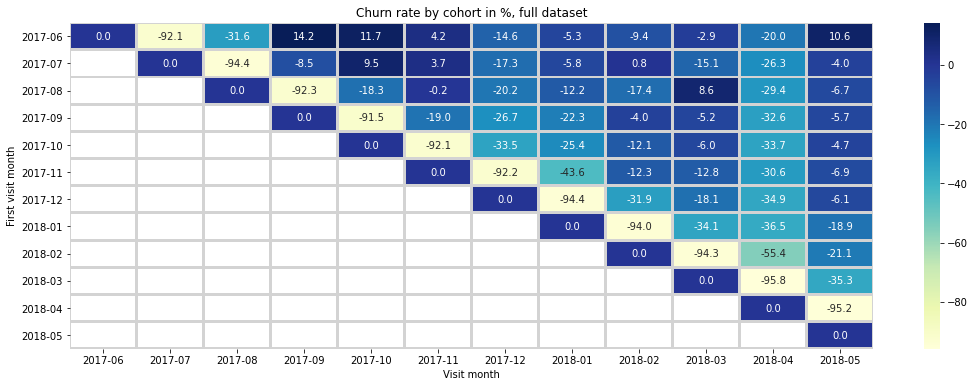

In [103]:
title = 'Churn rate by cohort in %, full dataset'
cohort_viz(churn_pivot, fmt = '.1f', title = title)

In [104]:
cohorts_two = visits.query('uid in @two_device_users').groupby(['first_visit_month',
                                                    'visit_month']).agg({'uid': 'nunique'}).reset_index()
cohorts_two['churn_rate'] = cohorts_two.groupby(['first_visit_month'])['uid'].pct_change()*100 
churn_pivot_two = cohorts_two.pivot_table(
    index='first_visit_month',
    columns='visit_month',
    values='churn_rate',
    aggfunc='sum',
)

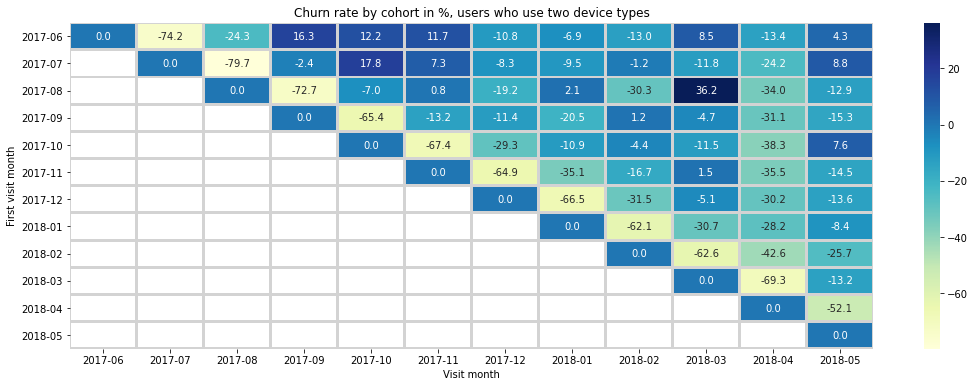

In [105]:
title = 'Churn rate by cohort in %, users who use two device types'
cohort_viz(churn_pivot_two, fmt = '.1f', title = title)

**As mentioned above, in general, less than 8% of the first month users got back to app in the following month, by the end of the period that percentage got even lower, appr. 5%. It can be the case that some campaign during September - November 2017 resulted in much better churn rates, but all the cohorts experienced a steep decline in December 2017. In April 2018 there was another steep decline in returning users. Users who use both desktops and touch devices churn less in the second month, but this group reveals a similar dynamics as all the users together; the spike in positive churn in March 2018 for the August 2017 cohort is much more obvious, it could be a nice idea for the product team to investigate possible reasons in more details.**

Let's calculate retention rates.

First, we will group the `visits` dataframe by cohorts and cohort lifetime and find the initial number of users in the cohort by looking at the 0th month:

In [106]:
visits.head(2)

,device,end_ts,source_id,start_ts,uid,duration_min,visit_year,visit_month,visit_week,visit_date,first_visit_date,first_visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18.0,2017,2017-12,51,2017-12-20,2017-12-20 17:20:00,2017-12,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28.0,2018,2018-02,8,2018-02-19,2018-02-19 16:53:00,2018-02,0


Let's use our `visits_pivot()` function to pivot the `visits` dataframe on `cohort_lifetime`:

In [107]:
cohorts_lft = visits_pivot(visits, columns = 'cohort_lifetime')

In [108]:
cohorts_lft

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,NaN
2017-08,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,NaN,NaN
2017-09,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,NaN,NaN,NaN
2017-10,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,NaN,NaN,NaN,NaN
2017-11,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,NaN,NaN,NaN,NaN,NaN
2017-12,25268.0,1410.0,960.0,786.0,512.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,22624.0,1351.0,890.0,565.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,22197.0,1267.0,565.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
initial_users_count = cohorts_lft[0]
initial_users_count.name = 'cohort_users'

Let's check out the initial cohort sizes:

In [110]:
initial_users_count

first_visit_month
2017-06    13259.0
2017-07    13140.0
2017-08    10181.0
2017-09    16704.0
2017-10    25977.0
2017-11    27248.0
2017-12    25268.0
2018-01    22624.0
2018-02    22197.0
2018-03    20589.0
2018-04    15709.0
2018-05    15273.0
Name: cohort_users, dtype: float64

Now we can calculate the retention rates:

In [111]:
coh_lft = pd.DataFrame()
for col in list(range(0,12)):
    coh_lft[col] = cohorts_lft[col] *100 / initial_users_count

In [112]:
coh_lft

,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06,100.0,7.866355,5.377479,6.139226,6.855721,7.142318,6.101516,5.777208,5.234181,5.083340,4.065163,4.49506
2017-07,100.0,5.608828,5.129376,5.616438,5.821918,4.817352,4.535769,4.573820,3.881279,2.861492,2.747336,NaN
2017-08,100.0,7.690797,6.286219,6.276397,5.009331,4.400354,3.634221,3.948532,2.789510,2.602888,NaN,NaN
2017-09,100.0,8.548851,6.920498,5.070642,3.939176,3.783525,3.585967,2.418582,2.280891,NaN,NaN,NaN
2017-10,100.0,7.860800,5.223852,3.895754,3.426108,3.222081,2.136505,2.036417,NaN,NaN,NaN,NaN
2017-11,100.0,7.828097,4.411333,3.868174,3.372725,2.341456,2.179977,NaN,NaN,NaN,NaN,NaN
2017-12,100.0,5.580180,3.799272,3.110654,2.026278,1.903593,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,100.0,5.971535,3.933876,2.497348,2.024399,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,100.0,5.707979,2.545389,2.009281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we visualize the retention rates by cohort lifetime.

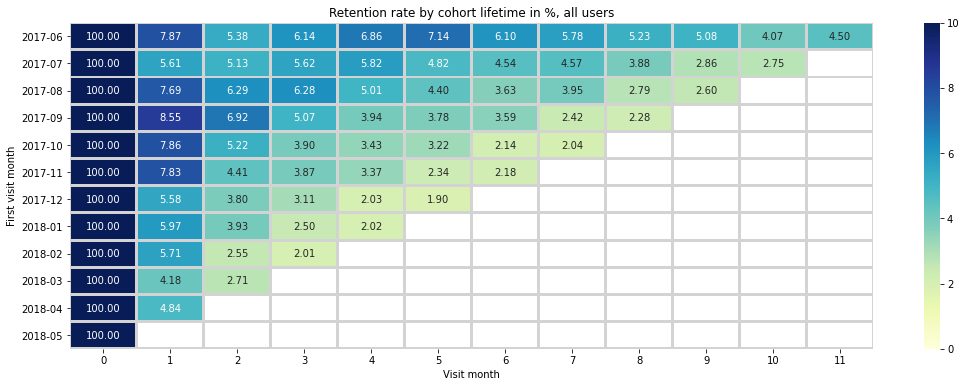

In [113]:
title = 'Retention rate by cohort lifetime in %, all users'
vmin = 0
vmax = 10
cohort_viz(coh_lft, fmt = '.2f', title = title, vmin = vmin, vmax = vmax)

**Now we can see that the June 2017 cohort is actually the most loyal one: compared to other cohorts, after 11 months it still had 4.5% user retention.**

### Summary on the product usage <a id='product_conclusions'></a>

1. The average number of people using the app every day is 907; on the weekly basis 5716 people on average use the app; on the monthly basis the average number of users is 23228.
2. Most users use the product using touch devices: the daily average of peole using the app from a touch device only is 557 out of 907 daily active users; there are users using the app both from a desktop and from a touch device, their share veries from ~8% of all daily active users to ~6% of all monthly active users.
3. There are on average 987 sessions on the daily basis, 6781 visit on the weekly basis and 29950 on the monthly basis for the period of time under consideration.
4. The average number of sessions per day equals 1.09, while users who use only desktop devices tend to make less visits and users who visit the app from either a touch device or from a desktop tend to perform 1.17 sessions per day on average. The same trend can be seen for weekly and monthly visits, while on the monthly basis the difference between the average number of sessions for monthly active users in total and the average number of visits for monthly active users using both types of devices becomes the most obvious.
5. The most frequent duration is one min and below for all users, desktop sessions tend to be shorter: 50 % of sessions last up to 3 minutes on a desktop and up to 5 min on a touch device, while users who use both type of devices tend to spent additional minute on the app.
6. Less than 8% of the users return to use the up even the month following the month of the first visit and by the end of the period under consideration the things got even worse: only about 4.8% of the first time user returned the month after. During the autumn and winter months the app attracted more users, which supposedly was the consequency of slightly higher marketing spendings.
7. Things are even worse for those users who use only desktop, compared to those who use only touch devices. The retention of those who use both desktops and touch devices is much higher. However, they churn fast anyway: less in the second month, but in the same manner that all the users together in the next months.
8. It can be the case that some campaign during September - November 2017 resulted in much better churn rates, but all the cohorts experienced a steep decline in December 2017. In April 2018 there was another steep decline in returning users.
9. There was a spike in positive churn in March 2018 for the August 2017 cohort, which would be good to investigate in more details.
10. Users from the June 2017 cohort turned the most loyal though.

[Back to Content](#content)

Now we will move on to analyzing the sales.

## Sales

The following questions are of the most interest for us:

- When do people start buying?
- How many orders do they make during a given period of time?
- What is the average purchase size?
- How much money do they bring? (LTV)

### When do people start buying?

To answer the first questions let's combine the `orders` data with the `first_visit_date_by_users`:

In [115]:
first_order_date_by_users = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_users.name = 'first_order_date'

In [116]:
orders_visits = orders.merge(first_visit_date_by_users, on = 'uid')

In [117]:
orders_visits = orders_visits.merge(first_order_date_by_users, on = 'uid')

We will add the time difference (in minutes) between the first order date and the first visit date.

In [118]:
orders_visits['delta'] = (orders_visits['first_order_date']
                          - orders_visits['first_visit_date'])/np.timedelta64(1,'m')

Now can build a pivot table showing first visit months vs. first order months and visualize it.

In [119]:
orders_visits['first_visit_month'] = orders_visits['first_visit_date'].dt.strftime('%Y-%m').astype('str')

In [120]:
orders_visits['first_order_month'] = orders_visits['first_order_date'].dt.strftime('%Y-%m').astype('str')

In [121]:
orders_visits.tail()

,buy_ts,revenue,uid,first_visit_date,first_order_date,delta,first_visit_month,first_order_month
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00,879.0,2018-05,2018-05
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00,45.0,2018-05,2018-05
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00,2.0,2018-05,2018-05
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,2018-05-31 23:56:00,317484.0,2017-10,2018-05
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-05-31 23:59:00,2018-06-01 00:02:00,3.0,2018-05,2018-06


In [122]:
# exclude one order from June 2018
orders_visits_pivot = orders_visits.query('first_order_month < "2018-06"').pivot_table(
    index='first_visit_month',
    columns='first_order_month',
    values='uid',
    aggfunc='nunique',
)

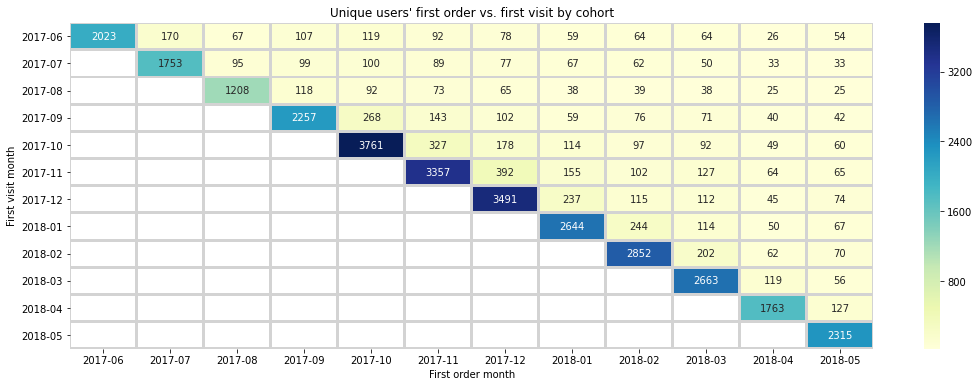

In [123]:
xlabel = "First order month"
ylabel = "First visit month"
title = "Unique users' first order vs. first visit by cohort"
cohort_viz(orders_visits_pivot, title = title, xlabel = xlabel, ylabel = ylabel)

**The absolute majority of users who ended up placing an order did this close to the date of the first visit (see the histogram below for more information on how close are the dates of the first order and the first visit). Between 5% and 10% of them returned and placed the first order in the following month. Interestingly, the better retention of the users in general in Autumn 2017 resulted in higher number of the first orders as well. There is also a long tail of users who placed their first order long after they visited the app for the first time (usually around 2% to 3% percent).**

Let's add a histogram to illustrate the distribution of the time difference between the first order date and the first visit date.

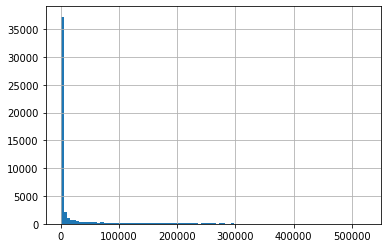

In [124]:
orders_visits['delta'].hist(bins = 100)
plt.show()

Let's zoom in a bit:

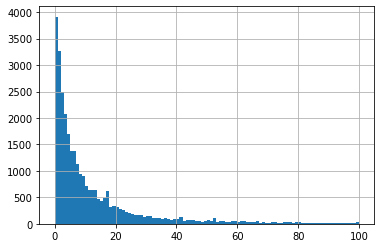

In [125]:
orders_visits['delta'].hist(bins = 100, range = (0,100))
plt.show()

**It turns out that appr. 3900 of first orders were performed within a minute from the first visit (the speed makes it a bit surprising) and the majority of first orders are performed within 20 minutes fron the first visit.**

[Back to Content](#content)

### How many orders do users make during a given period of time?

We are moving on with the `orders_visits` dataset:

In [126]:
orders_visits.head(1)

,buy_ts,revenue,uid,first_visit_date,first_order_date,delta,first_visit_month,first_order_month
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,1.0,2017-06,2017-06


In [127]:
orders_visits['cohort_lifetime'] = (pd.to_datetime(orders_visits['buy_ts'].dt.strftime('%Y-%m'))
                                    - pd.to_datetime(orders_visits['first_order_date'].dt.strftime('%Y-%m'))
                                   )
orders_visits['cohort_lifetime'] = orders_visits['cohort_lifetime'] / np.timedelta64(1, 'M')
orders_visits['cohort_lifetime'] = round(orders_visits['cohort_lifetime']).astype('int')

In [128]:
orders_visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 9 columns):
buy_ts               50415 non-null datetime64[ns]
revenue              50415 non-null float64
uid                  50415 non-null uint64
first_visit_date     50415 non-null datetime64[ns]
first_order_date     50415 non-null datetime64[ns]
delta                50415 non-null float64
first_visit_month    50415 non-null object
first_order_month    50415 non-null object
cohort_lifetime      50415 non-null int64
dtypes: datetime64[ns](3), float64(2), int64(1), object(2), uint64(1)
memory usage: 3.8+ MB


In [129]:
orders_visits['first_order_month'] = orders_visits['first_order_date'].dt.strftime('%Y-%m').astype('str')

In [130]:
orders_visits['order_month'] = orders_visits['buy_ts'].dt.strftime('%Y-%m').astype('str')

In [131]:
# exclude one order from June 2018
orders_pivot = orders_visits.query('first_order_month < "2018-06"').pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='uid',
    aggfunc='count',
)

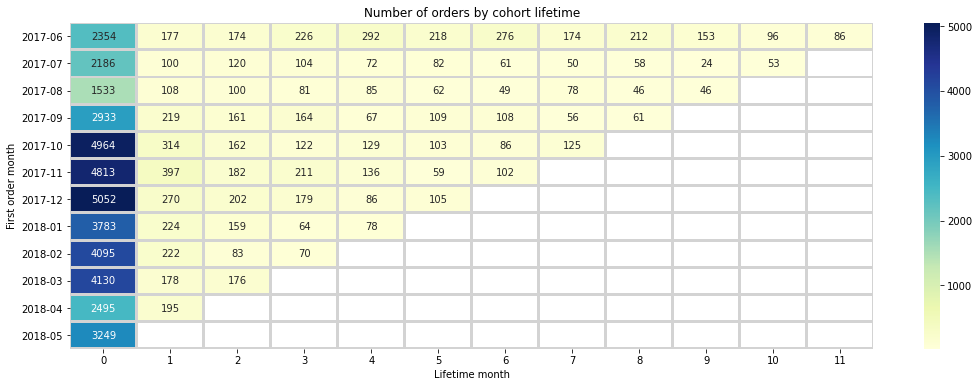

In [132]:
xlabel = "Lifetime month"
ylabel = "First order month"
title = "Number of orders by cohort lifetime"
cohort_viz(orders_pivot, title = title, xlabel = xlabel, ylabel = ylabel)

**Several observations are worth mentioning at this step: high number of orders for the June 2017 cohort during their first 10 months and a local peak in order numbers for June 2017 and September 2017 cohorts in the month of February 2018. October 2017 to December 2017 cohorts experiences some splash in May 2018.**

Let's prepare a pivot table which will contain the number of buyers by cohort and month:

In [133]:
buyers_pivot = orders_visits.query('first_order_month < "2018-06"').pivot_table( # exclude one order from June 2018
    index='first_order_month',
    columns='cohort_lifetime',
    values='uid',
    aggfunc='nunique',
)

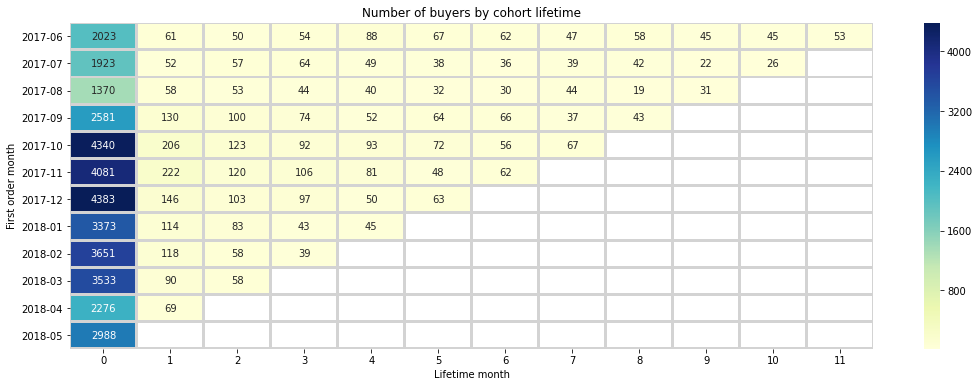

In [134]:
xlabel = "Lifetime month"
ylabel = "First order month"
title = "Number of buyers by cohort lifetime"
cohort_viz(buyers_pivot, fmt = '.0f', title = title, xlabel = xlabel, ylabel = ylabel)

**As we have already seen in the case of the order number, the number of regular buyer is actually very small in each cohort.**

Now we will combine the last two pivot tables and calculate the average number of orders per buyer and turn the resulting calculations into another cohort-based pivot table:

In [135]:
orders_per_buyer_pivot = pd.DataFrame(buyers_pivot.index)
for col in buyers_pivot.columns.to_list():
    orders_per_buyer_pivot = orders_per_buyer_pivot.merge(orders_pivot[col]
                                                            / buyers_pivot[col], on = 'first_order_month')
orders_per_buyer_pivot = orders_per_buyer_pivot.set_index('first_order_month')

Let's visualize the result:

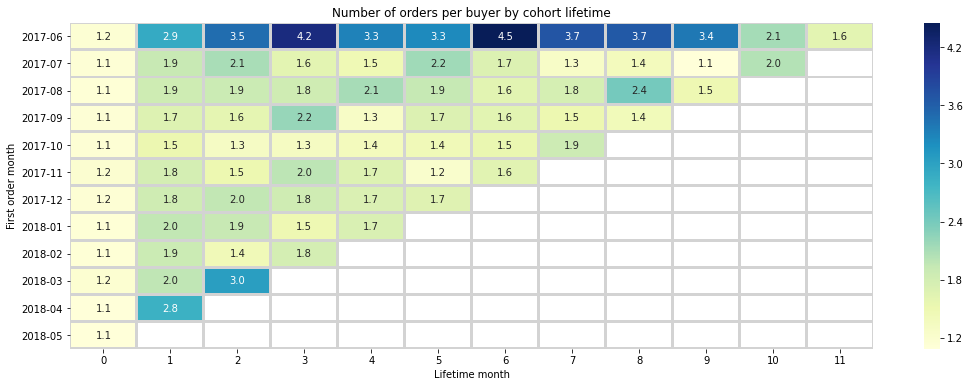

In [136]:
xlabel = "Lifetime month"
ylabel = "First order month"
title = "Number of orders per buyer by cohort lifetime"
cohort_viz(orders_per_buyer_pivot, fmt = '.1f', title = title, xlabel = xlabel, ylabel = ylabel)

**We have learned that in the first month after the first order appr. 10% of the buyers can place additional order, thus resulting in 1.1 order in average for the first order month. In addition, we are witnessing additional expression of the loyalty of the very first cohort: the buyers from this cohort placed much more orders on average during the period of 10 months within their first purchase, with the maximum of 4.5 order in December 2017. In general, the average number of orders per buyer in the month of December 2017 was higher for 5 cohorts out of 6. Some sign of a boost in the number of orders can be noticed for the spring cohorts of 2018, but the data is insufficient and additional investigation is necessary to be able to derive conclusions on possible trends.**

Let's move on to the next question.

[Back to Content](#content)

### What is the average purchase size?

Let's recall how the `orders_visits` dataframe looks like:

In [137]:
orders_visits.head(10)

,buy_ts,revenue,uid,first_visit_date,first_order_date,delta,first_visit_month,first_order_month,cohort_lifetime,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,1.0,2017-06,2017-06,0,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,11.0,2017-06,2017-06,0,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,2.0,2017-06,2017-06,0,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,15.0,2017-06,2017-06,0,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,27.0,2017-06,2017-06,0,2017-06
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01 08:43:00,0.0,2017-06,2017-06,0,2017-06
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:51:00,2017-06-01 08:54:00,3.0,2017-06,2017-06,0,2017-06
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:51:00,2017-06-01 08:54:00,3.0,2017-06,2017-06,0,2017-06
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0.0,2017-06,2017-06,0,2017-06
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0.0,2017-06,2017-06,0,2017-06


To calculate the average purchase size we have to devide the total revenue for a given period of time by the number of orders for that period. Let's prepare a pivot table which will contain the total revenue by cohort and month:


In [138]:
revenue_pivot = orders_visits.query('first_order_month < "2018-06"').pivot_table( # exclude one order from June 2018
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue',
    aggfunc='sum',
)

Now we will combine the `orders_pivot` and the `revenue_pivot` the same way as in the previous case, when we calculated the average number of orders per buyer.

In [139]:
purchase_size_pivot = pd.DataFrame(orders_pivot.index)
for col in orders_pivot.columns.to_list():
    purchase_size_pivot = purchase_size_pivot.merge(revenue_pivot[col]
                                                          / orders_pivot[col], on = 'first_order_month')
purchase_size_pivot = purchase_size_pivot.set_index('first_order_month')

Let's visualize the result:

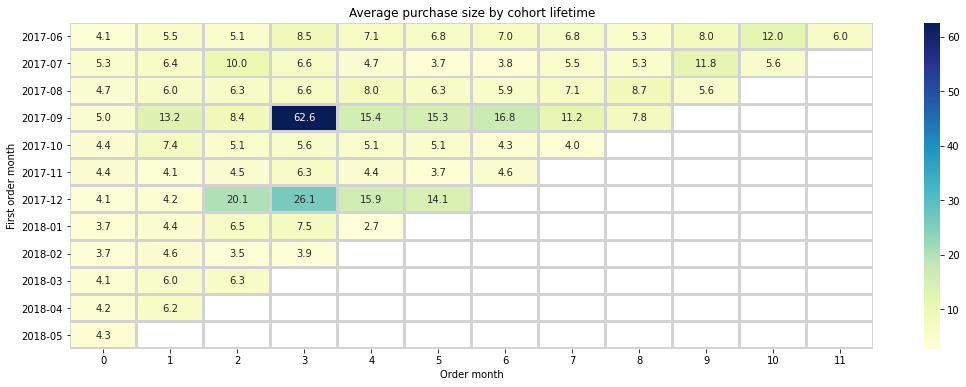

In [140]:
xlabel = "Order month"
ylabel = "First order month"
title = "Average purchase size by cohort lifetime"
cohort_viz(purchase_size_pivot, fmt = '.1f', title = title, xlabel = xlabel, ylabel = ylabel)

Let's add the overall average purchase size across the whole dataset:

In [141]:
round(purchase_size_pivot.mean().mean(),1)

7.7

**The overall average purchase size across the whole dataset equals 7.2 units and, as can be seen from the pivot table above, can be impacted by some outliers. The average size of a purchase within the first order month varies between 3.7 and 5.3 units and could be a bit higher in the following months. There were two interesting developments in September 2017 and December 2017 cohorts: the average purchase size becomes much higher than the overall average in December 2017 and February 2018 correspondingly and remains to be relativly high for at least four consecutive months.**

Let's inspect the December 2017 order details for the September 2017 cohort:

In [142]:
orders_visits[(
    orders_visits['first_order_month'] == '2017-09') & (
    orders_visits['order_month'] == '2017-12')]['revenue'].describe()

count     164.000000
mean       62.570244
std       237.649021
min         0.030000
25%         1.575000
50%         5.530000
75%        27.577500
max      2633.280000
Name: revenue, dtype: float64

We can see that 75% of the orders are below 27.6 units and there is one significant outlier, the maximum value, which equals 2633.3 units, which alone adds appr. 16 units to the average purchase size for the subset under consideration. Nevertheless, the boost on the average purchase size for this specific case remains obvious - 20 out of 164 orders (more then 12%) were above 100 units:

In [143]:
len(
    orders_visits[(orders_visits['first_order_month'] == '2017-09') & (
    orders_visits['order_month'] == '2017-12') & (orders_visits['revenue'] > 100)]
)

20

Let's add a mean revenue by month graph.

In [144]:
revenue_mean = orders_visits.query('first_order_month < "2018-06"').pivot_table( # exclude one order from June 2018
    index='order_month',
    values='revenue',
    aggfunc='mean',
)

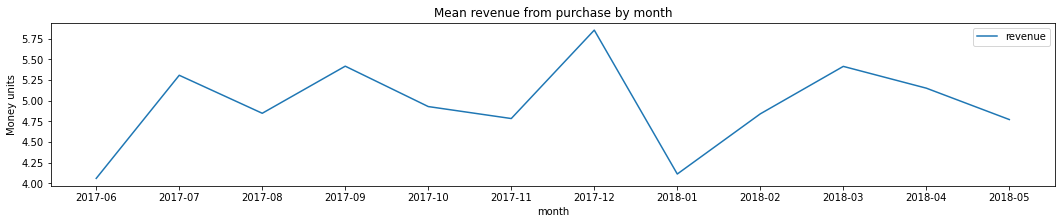

In [145]:
plt.figure(figsize=(18, 3))
sns.lineplot(data = revenue_mean)
plt.ymin = 0
plt.xlabel("month")
plt.ylabel("Money units")
plt.title(f"Mean revenue from purchase by month")
plt.show()

Next, lifetime value of the customers.

[Back to Content](#content)

### LTV

Usually, LTV is calculated on the basis of gross profit rather than revenue, but we have not been provided with the profitability rate to multiply the revenue by it.

We continue to work with the `orders_visits` dataframe. Let's sum up the buyers' cohort sizes and total revenue by cohort:

In [146]:
cohort_sizes = orders_visits.query('order_month < "2018-06"').groupby(['first_order_month']).agg({'uid': 'nunique', 'cohort_lifetime': 'max'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers', 'cohort_lifetime']
cohort_sizes

,first_order_month,n_buyers,cohort_lifetime
0,2017-06,2023,11
1,2017-07,1923,10
2,2017-08,1370,9
3,2017-09,2581,8
4,2017-10,4340,7
5,2017-11,4081,6
6,2017-12,4383,5
7,2018-01,3373,4
8,2018-02,3651,3
9,2018-03,3533,2


In [147]:
cohort_revenue = revenue_pivot.sum(axis = 1)
cohort_revenue.name = 'total_cohort_revenue'

In [148]:
ltv_report = pd.merge(cohort_sizes, cohort_revenue, on='first_order_month')

In [149]:
ltv_report['ltv'] = ltv_report['total_cohort_revenue'] / ltv_report['n_buyers']

In [150]:
ltv_report

,first_order_month,n_buyers,cohort_lifetime,total_cohort_revenue,ltv
0,2017-06,2023,11,24031.69,11.879234
1,2017-07,1923,10,16127.92,8.386854
2,2017-08,1370,9,11606.26,8.471723
3,2017-09,2581,8,34676.32,13.435227
4,2017-10,4340,7,27603.45,6.360242
5,2017-11,4081,6,26098.99,6.395244
6,2017-12,4383,5,33485.74,7.639913
7,2018-01,3373,4,16663.13,4.940151
8,2018-02,3651,3,16750.50,4.587921
9,2018-03,3533,2,19273.41,5.455253


**Since the number of regular buyers is very low, the lifetime value of the customers, especially compared with the average purchase size, is very low. As expected, in accordance with the previous observations, the LTV of June 2017 and September 2017 cohorts are slightly higher.**

Let's illustrate this result. It's worth stressing that we are dealing with a metric estimate based on a one year sample; thus, be able to derive any meaningful conclusions and make the result actionable, we will add a trend line by running a simple regression model. First, let's see the data points:

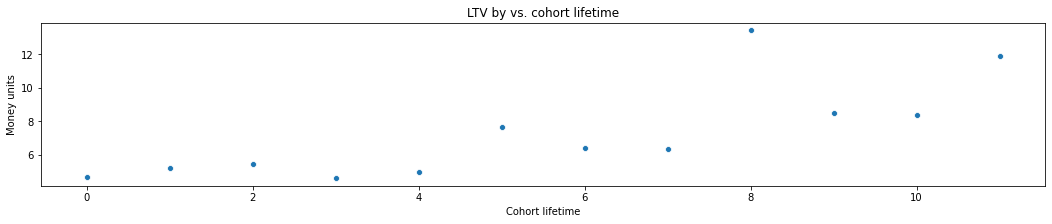

In [151]:
plt.figure(figsize=(18, 3))
sns.scatterplot(x = 'cohort_lifetime', y = 'ltv', data = ltv_report)
plt.xlabel("Cohort lifetime")
plt.ylabel("Money units")
plt.title(f"LTV by vs. cohort lifetime")
plt.show()

We know already, that the results for `8` and `11` months are biased due to the outliers, otherwise this series can be modelled with a simple linear regression. In the presence of outliers, it is preferable to fit a robust regression: it uses a special loss function to downweight relatively large residuals:

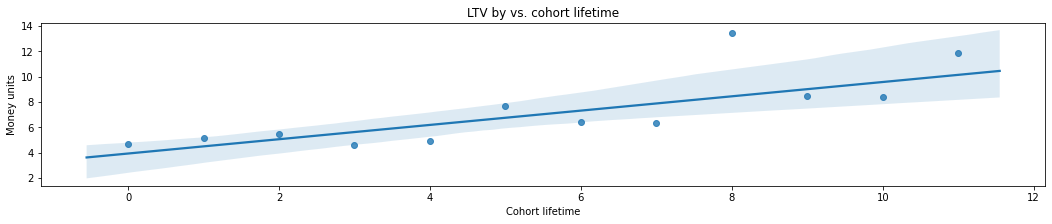

In [152]:
# NOTE: Sometimes the regression fails, run the cell several times
plt.figure(figsize=(18, 3))
sns.regplot(x = 'cohort_lifetime', y = 'ltv', data = ltv_report, robust = True)
plt.xlabel("Cohort lifetime")
plt.ylabel("Money units")
plt.title(f"LTV by vs. cohort lifetime")
plt.show()

**The simple linear regression model suggests that, if nothing changes, one can expect the LTV to be around 10 money units even after 11 months.**

In [153]:
# Let's construct a pivot table which will show the LTV in cumulative terms
ltv_pivot = pd.DataFrame()
s = cohort_sizes[['first_order_month', 'n_buyers']].set_index('first_order_month')['n_buyers']
for col in revenue_pivot.columns.to_list():
    ltv_pivot[col] = revenue_pivot[col] / s

In [154]:
ltv_pivot_cumsum = ltv_pivot.cumsum(axis=1)

In [155]:
ltv_pivot_cumsum

,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


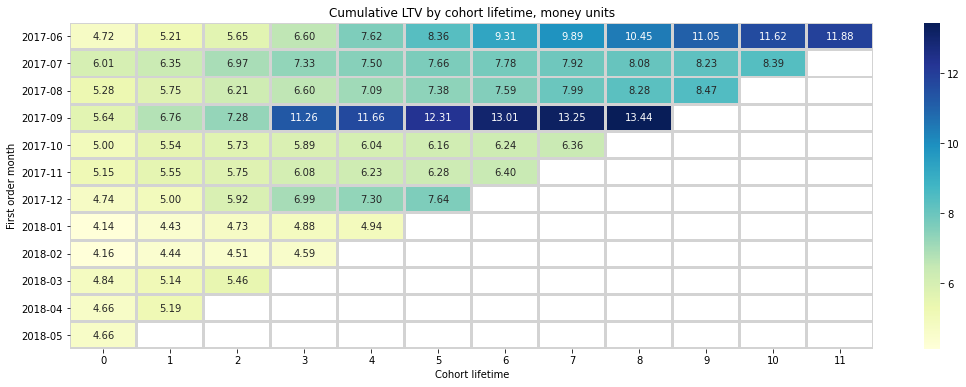

In [156]:
xlabel = "Cohort lifetime"
ylabel = "First order month"
title = "Cumulative LTV by cohort lifetime, money units"
cohort_viz(ltv_pivot_cumsum, fmt = '.2f', title = title, xlabel = xlabel, ylabel = ylabel)

### Summary on the sales <a id='sales_conclusions'></a>

1. The absolute majority of users who ended up placing an order did this close to the date of the first visit; actually, the majority of first orders are performed within 20 minutes fron the first visit. Between 5% and 10% of them returned and placed the first order in the following month. Interestingly, the better retention of the users in general in Autumn 2017 resulted in higher number of the first orders as well. There is also a long tail of users who placed their first order long after they visited the app for the first time (usually around 2% to 3% percent).
2. There was high number of orders for the first, June 2017, cohort during their first 10 months and a local peak in order numbers for June 2017 and September 2017 cohorts in the month of February 2018. October 2017 to December 2017 cohorts experiences some splash in May 2018.
3. The number of regular buyer is actually very small in each cohort, several dozens vs. 2K to 4K of first time buyers.
4. Within the first month after the first order appr. 10% of the buyers can place additional order, thus resulting in 1.1 order in average for the first order month.
5. In addition, we have seen additional expression of the loyalty of the very first cohort: the buyers from this cohort placed much more orders on average during the period of 10 months within their first purchase, with the maximum of 4.5 order in December 2017.
6. In general, the average number of orders per buyer in the month of December 2017 was higher for 5 cohorts out of 6. Some sign of a boost in the number of orders could be noticed for the spring cohorts of 2018, but the data is insufficient and additional investigation is necessary to be able to derive conclusions on possible trends.
7. The overall average purchase size across the whole dataset was equal to 7.2 units and was impacted by some outliers.
8. The average size of a purchase within the first order month varies between 3.7 and 5.3 units and could be a bit higher in the following months.
9. There were two interesting developments in September 2017 and December 2017 cohorts: the average purchase size was much higher than the overall average in December 2017 and February 2018 correspondingly and remained to be relativly high for at least four consecutive months.
10. Since the number of returning buyers was low, the lifetime value of the customers, especially compared with the average purchase size, is very low: a simple linear regression model suggests that, if nothing changes, one can expect the LTV to be around 10 money units even after 11 months. As expected, in accordance to the previous observations, the LTV of June 2017 and September 2017 cohorts are slightly higher.


[Back to Content](#content)

Let's move on to the marketing expenses.

## Marketing

With regard to the marketing expenses, we will search for answer to the following questions:

- How much money was spent? Overall/per source/over time
- How much did customer acquisition from each of the sources cost?
- How worthwhile where the investments? (ROI)

### How much money was spent? Overall/per source/over time

Let's recap how the `costs` dataset looks like.

In [157]:
costs.head(1)

,source_id,dt,costs
0,1,2017-06-01,75.2


In [158]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

In [159]:
costs['costs'].sum()

329131.62

In [160]:
costs_pivot = costs.pivot_table(index = 'dt', columns = 'source_id', values = 'costs', aggfunc = 'sum')
costs_pivot

source_id,1,2,3,4,5,9,10
dt,,,,,,,
2017-06-01,75.20,132.56,349.38,76.74,73.24,13.06,15.08
2017-06-02,62.25,132.38,314.22,59.21,123.82,18.13,11.18
2017-06-03,36.53,77.20,196.12,59.39,64.93,7.06,9.62
2017-06-04,55.00,79.08,389.87,161.97,52.77,4.65,17.82
2017-06-05,57.08,108.96,424.47,44.65,144.30,15.30,26.68
...,...,...,...,...,...,...,...
2018-05-27,30.89,113.35,254.90,28.04,84.66,11.11,9.92
2018-05-28,54.47,82.67,247.92,68.88,131.77,12.47,21.26
2018-05-29,61.13,105.75,347.59,103.84,138.33,16.83,11.32


In [161]:
costs.groupby('source_id').agg({'costs': 'sum'}).sort_values(by = 'costs',
                                                    ascending = False) / costs.sum().sum()

,costs
source_id,
3,0.413852
4,0.178850
5,0.151568
2,0.125355
1,0.061009
10,0.017051
9,0.016158


**We have daily data for seven marketing sources. The overall marketing spending for the given period was 341478.62 units, the median daily spending across sources was 77.3 units, the maximum - 1788.3 units. More than 41% of this sum was spent on source `3`. Sources `3`, `4`, and `5` took almost 75% of the overall marketing spending for the given period.**

Let's illustrate the dynamics of the marketing spendings.

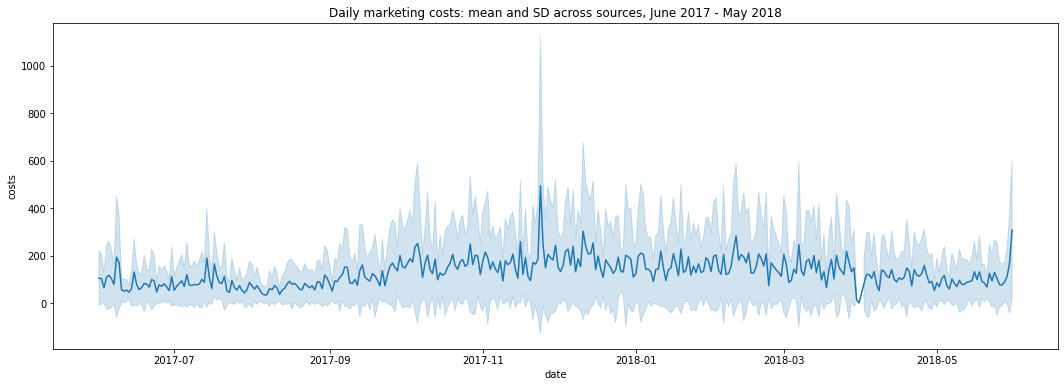

In [162]:
plt.figure(figsize=(18, 6))
sns.lineplot(y = 'costs', x = 'dt', data = costs, ci = 'sd')
plt.xlabel("date")
plt.title("Daily marketing costs: mean and SD across sources, June 2017 - May 2018")
plt.show()

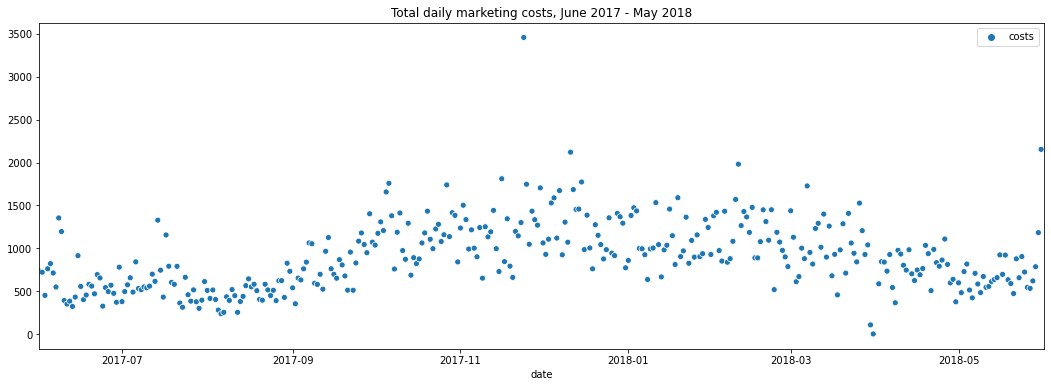

In [163]:
plt.figure(figsize=(18, 6))
costs_time = costs.groupby('dt').agg({'costs': 'sum'})
sns.scatterplot(data = costs_time)
plt.xlim('2017-06-01', '2018-06-01')
plt.xlabel("date")
plt.title("Total daily marketing costs, June 2017 - May 2018")
plt.show()

Let's make some zoom in into the period of the most spendings:

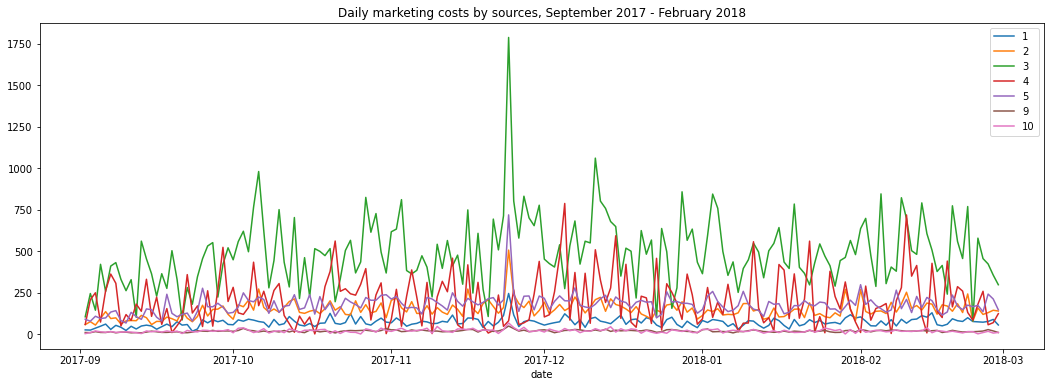

In [164]:
plt.figure(figsize=(18, 6))
sns.lineplot(data = costs_pivot[(costs_pivot.index > "2017-09-01") & (costs_pivot.index < "2018-03-01")], dashes=False)
plt.xlabel("date")
plt.title("Daily marketing costs by sources, September 2017 - February 2018")
plt.show()

**Back to our previous observations with regard to more visitors/customers attracted in autumn and winter and higher average number of orders, we indeed see the grow in marketing spending starting from September 2017 and its later decay in April 2018.**

[Back to Content](#content)

### How much did customer acquisition from each of the sources cost?

To calculate the CAC, we will divide the costs for source and month by the number of buyers. First, buyers.

Actually, we need to calculate number of buyers by marketing source.

#### Connecting orders to marketing sources which the buyers came from <a id='approach'></a>

To better understand the CAC and the revenue flow from different marketing sources, we have to connect between the `uid`'s in the `orders` dataset and the `source_id` in the `costs` dataset. The goals is to find source for each order: **we will employ the plain vanilla assumption that the last source before a particular order was the one that brought the buyer**. Let's start by extracting user id's from `visits` together with their `source_id`.

In [165]:
user_source = visits[['uid', 'source_id', 'end_ts']].drop_duplicates()

In [166]:
user_source.head()

,uid,source_id,end_ts
0,16879256277535980062,4,2017-12-20 17:38:00
1,104060357244891740,2,2018-02-19 17:21:00
2,7459035603376831527,5,2017-07-01 01:54:00
3,16174680259334210214,9,2018-05-20 11:23:00
4,9969694820036681168,3,2017-12-27 14:06:00


In [167]:
user_source.groupby('uid').agg({'source_id': 'count'}).head()

,source_id
uid,
11863502262781,1
49537067089222,1
297729379853735,1
313578113262317,3
325320750514679,2


There are visitors, who came from different sources in different `visit_date`'s. As we have already stated, we will employ the plain vanilla assumption that the last source before a particular order was the one that brought the buyer. Let's extract users who placed at least one order together with their `buy_ts`, `revenue`, `end_ts` and `source_id`.

In [168]:
uid_order_date = orders[['uid', 'buy_ts', 'revenue']].drop_duplicates()

In [169]:
buyer_source = user_source.merge(uid_order_date, on = 'uid')

Now we have to keep only the rows with the closest dates of visits and first orders. To this end, we will:

1. Calculate the time difference between the end of the session and the order timestamp;
2. Filter those artifacts for which the difference takes negative values (we assume that the buying sessions ends after the transaction is completed);
3. Find the entries with minimal time difference.

In [170]:
buyer_source.head()

,uid,source_id,end_ts,buy_ts,revenue
0,16174680259334210214,9,2018-05-20 11:23:00,2018-03-09 20:25:00,2.33
1,16174680259334210214,4,2018-03-09 20:33:00,2018-03-09 20:25:00,2.33
2,16007536194108375387,5,2017-09-03 21:36:00,2017-09-04 12:46:00,2.44
3,16007536194108375387,5,2017-09-03 21:36:00,2017-10-28 00:01:00,1.53
4,16007536194108375387,5,2017-09-03 21:36:00,2017-10-28 19:16:00,1.53


In [171]:
buyer_source['time_delta'] = buyer_source['end_ts'] - buyer_source['buy_ts']

We will convert the `time_delta` into seconds.

In [172]:
buyer_source['time_delta'] = buyer_source['time_delta']/ np.timedelta64(1, 's')

In [173]:
buyer_source.head(10)

,uid,source_id,end_ts,buy_ts,revenue,time_delta
0,16174680259334210214,9,2018-05-20 11:23:00,2018-03-09 20:25:00,2.33,6188280.0
1,16174680259334210214,4,2018-03-09 20:33:00,2018-03-09 20:25:00,2.33,480.0
2,16007536194108375387,5,2017-09-03 21:36:00,2017-09-04 12:46:00,2.44,-54600.0
3,16007536194108375387,5,2017-09-03 21:36:00,2017-10-28 00:01:00,1.53,-4674300.0
4,16007536194108375387,5,2017-09-03 21:36:00,2017-10-28 19:16:00,1.53,-4743600.0
5,16007536194108375387,3,2017-10-27 16:02:00,2017-09-04 12:46:00,2.44,4590960.0
6,16007536194108375387,3,2017-10-27 16:02:00,2017-10-28 00:01:00,1.53,-28740.0
7,16007536194108375387,3,2017-10-27 16:02:00,2017-10-28 19:16:00,1.53,-98040.0
8,16007536194108375387,4,2017-09-04 17:56:00,2017-09-04 12:46:00,2.44,18600.0
9,16007536194108375387,4,2017-09-04 17:56:00,2017-10-28 00:01:00,1.53,-4601100.0


We are not interested in the pairs when `end_ts` was less then `buy_ts` (as it was mentioned above, we assume that the buying sessions ends after the transaction is completed):

In [174]:
buyer_source = buyer_source.query('time_delta >= 0')

In [175]:
buyer_source.head(10)

,uid,source_id,end_ts,buy_ts,revenue,time_delta
0,16174680259334210214,9,2018-05-20 11:23:00,2018-03-09 20:25:00,2.33,6188280.0
1,16174680259334210214,4,2018-03-09 20:33:00,2018-03-09 20:25:00,2.33,480.0
5,16007536194108375387,3,2017-10-27 16:02:00,2017-09-04 12:46:00,2.44,4590960.0
8,16007536194108375387,4,2017-09-04 17:56:00,2017-09-04 12:46:00,2.44,18600.0
11,16007536194108375387,3,2017-10-28 00:04:00,2017-09-04 12:46:00,2.44,4619880.0
12,16007536194108375387,3,2017-10-28 00:04:00,2017-10-28 00:01:00,1.53,180.0
14,16007536194108375387,3,2017-10-30 11:41:00,2017-09-04 12:46:00,2.44,4834500.0
15,16007536194108375387,3,2017-10-30 11:41:00,2017-10-28 00:01:00,1.53,214800.0
16,16007536194108375387,3,2017-10-30 11:41:00,2017-10-28 19:16:00,1.53,145500.0
17,16007536194108375387,4,2017-09-24 14:31:00,2017-09-04 12:46:00,2.44,1734300.0


Now we are interested to find the minimal `time_delta`:

In [176]:
buyers_min_time_delta = buyer_source.groupby('uid').agg({'time_delta': 'min'})

In [177]:
buyers_min_time_delta.columns = ['min_time_delta']
buyers_min_time_delta.head()

,min_time_delta
uid,
313578113262317,3951300.0
1575281904278712,240.0
2551852515556206,19.0
3077748354309989,300.0
3605148382144603,540.0


Let's add the `min_time_delta` column to the `buyer_source` dataframe:

In [178]:
buyer_source = buyer_source.merge(buyers_min_time_delta, on = 'uid')

In [179]:
buyer_source.head(10)

,uid,source_id,end_ts,buy_ts,revenue,time_delta,min_time_delta
0,16174680259334210214,9,2018-05-20 11:23:00,2018-03-09 20:25:00,2.33,6188280.0,480.0
1,16174680259334210214,4,2018-03-09 20:33:00,2018-03-09 20:25:00,2.33,480.0,480.0
2,16007536194108375387,3,2017-10-27 16:02:00,2017-09-04 12:46:00,2.44,4590960.0,180.0
3,16007536194108375387,4,2017-09-04 17:56:00,2017-09-04 12:46:00,2.44,18600.0,180.0
4,16007536194108375387,3,2017-10-28 00:04:00,2017-09-04 12:46:00,2.44,4619880.0,180.0
5,16007536194108375387,3,2017-10-28 00:04:00,2017-10-28 00:01:00,1.53,180.0,180.0
6,16007536194108375387,3,2017-10-30 11:41:00,2017-09-04 12:46:00,2.44,4834500.0,180.0
7,16007536194108375387,3,2017-10-30 11:41:00,2017-10-28 00:01:00,1.53,214800.0,180.0
8,16007536194108375387,3,2017-10-30 11:41:00,2017-10-28 19:16:00,1.53,145500.0,180.0
9,16007536194108375387,4,2017-09-24 14:31:00,2017-09-04 12:46:00,2.44,1734300.0,180.0


Now we can filter only those rows for which `time_delta` equals `min_time_delta`:

In [180]:
buyer_source = buyer_source.query('time_delta == min_time_delta')

In [181]:
buyer_source.head(10)

,uid,source_id,end_ts,buy_ts,revenue,time_delta,min_time_delta
1,16174680259334210214,4,2018-03-09 20:33:00,2018-03-09 20:25:00,2.33,480.0,480.0
5,16007536194108375387,3,2017-10-28 00:04:00,2017-10-28 00:01:00,1.53,180.0,180.0
142,8056418121947262981,2,2018-03-06 14:21:00,2018-03-06 14:21:00,3.05,0.0,0.0
3491,8056418121947262981,2,2018-01-23 14:11:00,2018-01-23 14:11:00,1.22,0.0,0.0
4089,8056418121947262981,5,2018-03-21 16:26:00,2018-03-21 16:26:00,4.28,0.0,0.0
4685,18188358787673499603,2,2018-02-13 20:13:00,2018-02-13 19:48:00,0.06,1500.0,1500.0
4687,2307401184189569202,5,2017-09-27 09:26:00,2017-09-27 09:23:00,3.67,180.0,180.0
4695,4499746016005494365,1,2017-11-16 23:39:00,2017-11-16 23:39:00,4.28,0.0,0.0
4729,15857957287537270437,3,2018-03-12 23:25:00,2018-03-12 23:17:00,1.83,480.0,480.0
4733,15763368622958393183,4,2018-03-09 09:51:00,2018-03-06 18:33:00,4.89,227880.0,227880.0


Now we can add `order_month` column to pivot the buyer_source dataframe.

In [182]:
buyer_source['order_month'] = buyer_source['buy_ts'].dt.strftime('%Y-%m').astype('str')

In [183]:
buyer_source.head(10)

,uid,source_id,end_ts,buy_ts,revenue,time_delta,min_time_delta,order_month
1,16174680259334210214,4,2018-03-09 20:33:00,2018-03-09 20:25:00,2.33,480.0,480.0,2018-03
5,16007536194108375387,3,2017-10-28 00:04:00,2017-10-28 00:01:00,1.53,180.0,180.0,2017-10
142,8056418121947262981,2,2018-03-06 14:21:00,2018-03-06 14:21:00,3.05,0.0,0.0,2018-03
3491,8056418121947262981,2,2018-01-23 14:11:00,2018-01-23 14:11:00,1.22,0.0,0.0,2018-01
4089,8056418121947262981,5,2018-03-21 16:26:00,2018-03-21 16:26:00,4.28,0.0,0.0,2018-03
4685,18188358787673499603,2,2018-02-13 20:13:00,2018-02-13 19:48:00,0.06,1500.0,1500.0,2018-02
4687,2307401184189569202,5,2017-09-27 09:26:00,2017-09-27 09:23:00,3.67,180.0,180.0,2017-09
4695,4499746016005494365,1,2017-11-16 23:39:00,2017-11-16 23:39:00,4.28,0.0,0.0,2017-11
4729,15857957287537270437,3,2018-03-12 23:25:00,2018-03-12 23:17:00,1.83,480.0,480.0,2018-03
4733,15763368622958393183,4,2018-03-09 09:51:00,2018-03-06 18:33:00,4.89,227880.0,227880.0,2018-03


Let's pivot the `buyers_source` dataframe on `source_id` and `order_month` to derive monthly unique buyers for different sources.

In [184]:
nbuyers_source_report = buyer_source.pivot_table(index = 'source_id',
                                               columns = 'order_month',
                                               values = 'uid',
                                               aggfunc = 'nunique')

In [185]:
# drop the one order from June 2018
nbuyers_source_report = nbuyers_source_report.drop(columns = ['2018-06'])

Thus, we derived the number of unique buyers by marketing source and month:

In [186]:
nbuyers_source_report

order_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,226.0,226.0,137.0,298.0,466.0,503.0,560.0,370.0,408.0,418.0,279.0,351.0
2,215.0,204.0,137.0,257.0,446.0,491.0,453.0,315.0,356.0,375.0,223.0,409.0
3,513.0,384.0,263.0,524.0,848.0,832.0,934.0,713.0,805.0,703.0,410.0,564.0
4,348.0,385.0,285.0,496.0,962.0,972.0,1126.0,845.0,889.0,829.0,541.0,600.0
5,362.0,387.0,297.0,544.0,871.0,591.0,662.0,581.0,641.0,566.0,417.0,515.0
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,49.0,45.0,45.0,56.0,107.0,116.0,100.0,78.0,65.0,144.0,30.0,43.0
10,84.0,44.0,36.0,64.0,172.0,102.0,64.0,76.0,118.0,128.0,94.0,101.0


We do not have spendings on `source_id` 7 and we have only one order for that source, so we can filter it out:

In [187]:
nbuyers_source_report = nbuyers_source_report.drop(7)

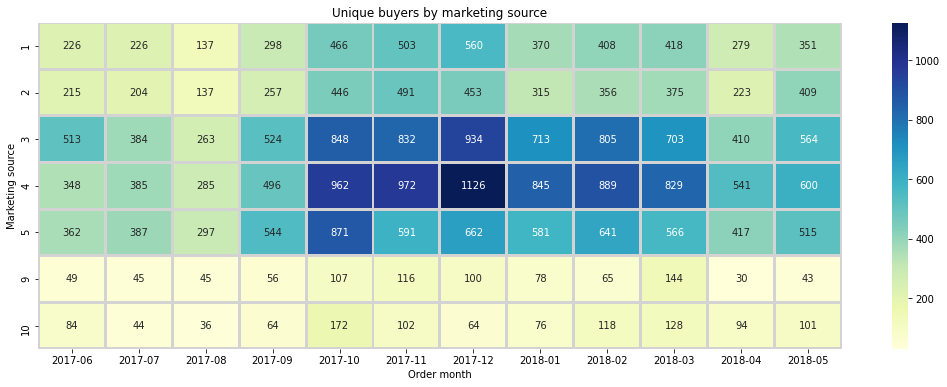

In [188]:
title = 'Unique buyers by marketing source'
ylabel = 'Marketing source'
xlabel = 'Order month'
cohort_viz(nbuyers_source_report, title = title, xlabel = xlabel, ylabel = ylabel)

Let's get back to the CAC.

[Back to Content](#content)

As we have already mentioned, to calculate the CAC, we will divide the costs for source and month by the number of buyers for the same source and month. Let's recap how the `costs` dataframe looks like.

In [189]:
costs.head(1)

,source_id,dt,costs
0,1,2017-06-01,75.2


We will derive a month column, call it `order_month` und use to merge two dataframes:

In [190]:
costs['order_month'] = costs['dt'].dt.strftime('%Y-%m').astype('str')
costs.head()

,source_id,dt,costs,order_month
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06


Thus, monthly marketing costs by source and month:

In [191]:
monthly_source_costs = costs.groupby(['source_id', 'order_month']).agg('sum').reset_index()
monthly_source_costs.head()

,source_id,order_month,costs
0,1,2017-06,1125.61
1,1,2017-07,1072.88
2,1,2017-08,951.81
3,1,2017-09,1502.01
4,1,2017-10,2315.75


Monthly unique buyers by source and month:

In [192]:
nbuyers_source_monthly = buyer_source.groupby(['source_id', 'order_month']).agg({'uid': 'nunique'}).reset_index()
nbuyers_source_monthly.head()

,source_id,order_month,uid
0,1,2017-06,226
1,1,2017-07,226
2,1,2017-08,137
3,1,2017-09,298
4,1,2017-10,466


Let's join these two dataframes:

In [193]:
cac_report = pd.merge(nbuyers_source_monthly, monthly_source_costs, on=['source_id','order_month'])

In [194]:
cac_report['cac'] = cac_report['costs'] / cac_report['uid']

In [195]:
cac_report.head(1)

,source_id,order_month,uid,costs,cac
0,1,2017-06,226,1125.61,4.980575


In [196]:
# Short check
cac_report['costs'].sum()

329131.62

Let's calculate and illustrate the overall monthly CAC:

In [197]:
cac_month = cac_report.groupby('order_month').agg({'uid': 'sum', 'costs': 'sum'}).reset_index()
cac_month['monthly_cac'] = cac_month['costs'] / cac_month['uid']
cac_month

,order_month,uid,costs,monthly_cac
0,2017-06,1797,18015.00,10.025042
1,2017-07,1675,18240.59,10.889904
2,2017-08,1200,14790.54,12.325450
3,2017-09,2239,24368.91,10.883837
4,2017-10,3872,36322.88,9.380909
5,2017-11,3607,37907.88,10.509531
6,2017-12,3899,38315.35,9.826968
7,2018-01,2978,33518.52,11.255379
8,2018-02,3282,32723.03,9.970454
9,2018-03,3163,30415.27,9.615956


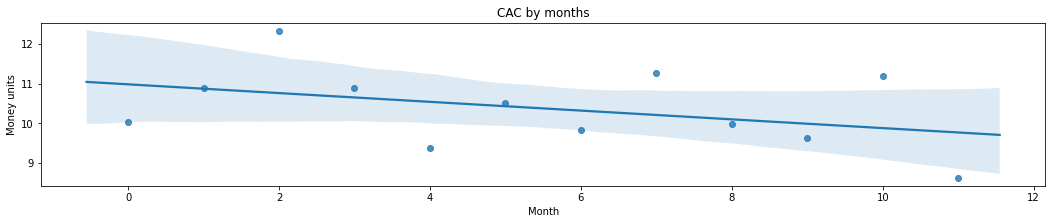

In [200]:
plt.figure(figsize=(18, 3))
# Employ index to enable regression analysis (takes numeric values only)
sns.regplot(x = cac_month.index.to_list(), y = 'monthly_cac', data = cac_month)
plt.xlabel("Month")
plt.ylabel("Money units")
plt.title(f"CAC by months")
plt.show()

**A simple linear regression model seems to be applicable in this case as well and it suggests that CAC is had been getting lower during the one-year period under consideration.**

Let's calculate and illustrate the monthly CAC by marketing sources:

In [201]:
cac_report.describe()

,source_id,uid,costs,cac
count,84.000000,84.000000,84.000000,84.000000
mean,4.857143,384.392857,3918.233571,9.204989
std,3.200688,276.098595,3991.439304,4.849259
min,1.000000,30.000000,232.570000,3.335347
25%,2.000000,125.500000,654.950000,5.872316
50%,4.000000,366.000000,2837.550000,7.458847
75%,9.000000,548.000000,5375.845000,10.969667
max,10.000000,1126.000000,17025.340000,23.359468


**CAC for different sources varied from 5.0 units per buyer on average for the source `1` up to 19.2 units per buyer on average for the source `3`. Source `10` was the next best after `1` and source `9` took the third place.**

Let's ploth CAC by source by month:

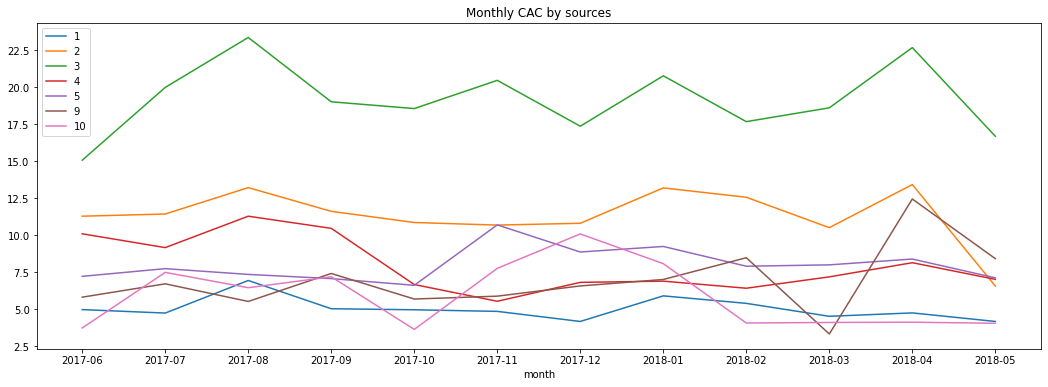

In [202]:
plt.figure(figsize=(18, 6))
cac_piv = cac_report.pivot_table(index = 'order_month', columns = 'source_id', values = 'cac', aggfunc = 'sum')
sns.lineplot(data = cac_piv, dashes = False)
plt.xlabel("month")
plt.title("Monthly CAC by sources")
plt.show()

**Sources `3` and `2` were the sources with of the lowest cost-efficiency, while source `1` can be seen as the most efficient one: source `10` makes competition to it, but is much more volitile.**

In [203]:
#Find the time of the first purchase of each customer 
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']
first_orders['first_order_dt'] = first_orders['first_order_ts'].dt.date
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')

#first source
users = visits.sort_values('start_ts').groupby('uid').first()
users = users[['source_id']]

#merge
buyers = pd.merge(first_orders, users, left_on='uid', right_index=True)

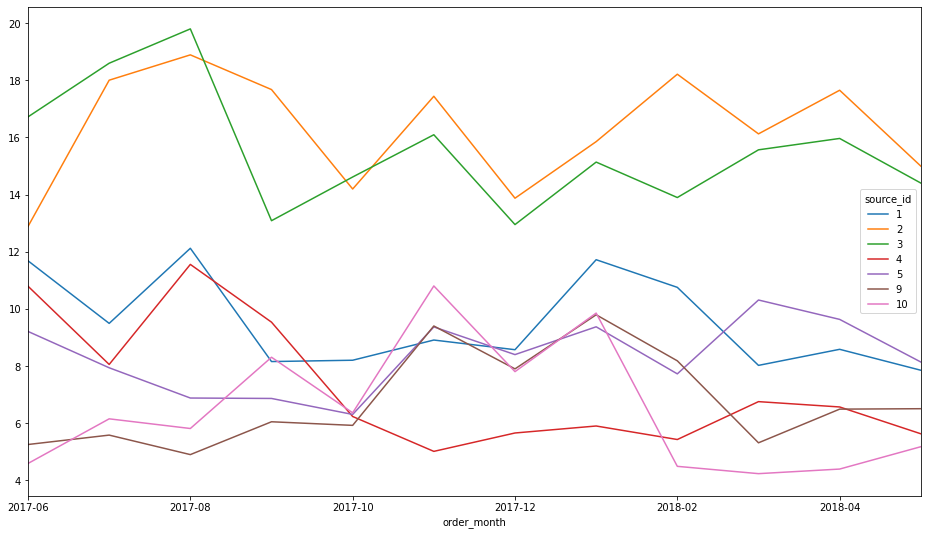

In [204]:
buyers_daily = buyers.groupby(['source_id', 'first_order_dt']).agg({'uid': 'count'}).reset_index()
buyers_daily.rename(columns={'uid': 'n_buyers'}, inplace=True)
buyers_daily['first_order_dt'] = pd.to_datetime(buyers_daily['first_order_dt'])

costs_ = pd.merge(buyers_daily, costs, left_on=['source_id', 'first_order_dt'], right_on=['source_id', 'dt'])
costs_['costs_per_buyer'] = costs_['costs']/costs_['n_buyers']

costs_.pivot_table(index=['order_month'], columns='source_id', values='costs_per_buyer', aggfunc='mean').plot(
    figsize=(16,9))
plt.show()

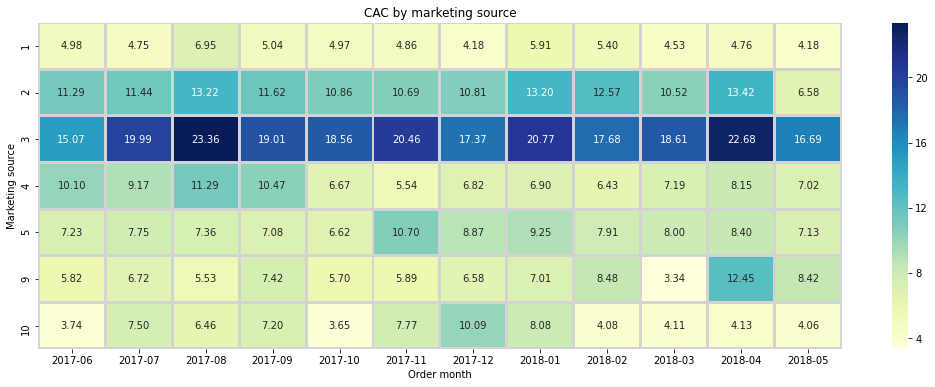

In [205]:
title = 'CAC by marketing source'
ylabel = 'Marketing source'
xlabel = 'Order month'
cohort_viz(cac_piv.T, fmt = '.2f', title = title, xlabel = xlabel, ylabel = ylabel)

[Back to Content](#content)

### How worthwhile where the investments? (ROI)

Let's join the `cac_month` and `ltv_report` dataframes:

In [206]:
investment_report = cac_month.join(ltv_report['ltv'])

In [207]:
investment_report

,order_month,uid,costs,monthly_cac,ltv
0,2017-06,1797,18015.00,10.025042,11.879234
1,2017-07,1675,18240.59,10.889904,8.386854
2,2017-08,1200,14790.54,12.325450,8.471723
3,2017-09,2239,24368.91,10.883837,13.435227
4,2017-10,3872,36322.88,9.380909,6.360242
5,2017-11,3607,37907.88,10.509531,6.395244
6,2017-12,3899,38315.35,9.826968,7.639913
7,2018-01,2978,33518.52,11.255379,4.940151
8,2018-02,3282,32723.03,9.970454,4.587921
9,2018-03,3163,30415.27,9.615956,5.455253


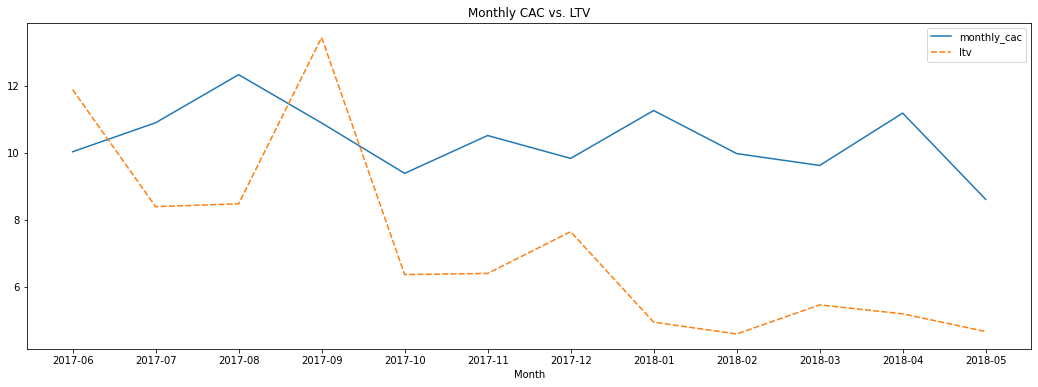

In [208]:
plt.figure(figsize=(18, 6))
df = investment_report[['order_month', 'monthly_cac', 'ltv']]
df = df.set_index('order_month')
sns.lineplot(data = df)
plt.xlabel("Month")
plt.title("Monthly CAC vs. LTV")
plt.show()

**One can immediately see that the overall investments in marketing does not seem to be worthwhile: the overall CAC is less than LTV only for the very first cohort, from June 2017, and for the September 2017 cohort. Following our discussion previously, the buyers from the June 2017 cohort happened to be relatively loyal, while several buyers from the September 2017 cohort spent unexpectedly high amount of money on purchases in winter (chances are with no relation to the grow in the marketing spendings which took place in the following months). There is not enough data to make conclusions about cohorts of 2018. Given the results with regard to LTV, the direct comparison between marketing costs and revenues from the orders in the given month seems to be the only way to estimate the marketing source efficiency.**

[Back to Content](#content)

### Relative efficiency of the marketing sources

Let's pivot the `buyers_source` dataframe on `source_id` and `order_month` to derive monthly order numbers for different sources.

In [209]:
orders_source_report = buyer_source.pivot_table(index = 'source_id',
                                               columns = 'order_month',
                                               values = 'uid',
                                               aggfunc = 'count')

In [210]:
# drop the one order from June 2018
orders_source_report = orders_source_report.drop(columns = ['2018-06'])

Monthly order number by marketing source:

In [211]:
orders_source_report

order_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,226.0,226.0,137.0,300.0,467.0,506.0,562.0,371.0,408.0,420.0,283.0,356.0
2,219.0,205.0,137.0,257.0,447.0,492.0,456.0,316.0,361.0,377.0,226.0,410.0
3,513.0,385.0,264.0,524.0,848.0,833.0,934.0,713.0,805.0,704.0,410.0,564.0
4,349.0,385.0,286.0,496.0,962.0,975.0,1126.0,846.0,890.0,831.0,541.0,602.0
5,363.0,389.0,297.0,546.0,874.0,592.0,669.0,581.0,643.0,574.0,418.0,520.0
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,49.0,45.0,45.0,56.0,107.0,116.0,100.0,78.0,65.0,144.0,30.0,43.0
10,84.0,44.0,36.0,64.0,173.0,102.0,64.0,76.0,118.0,128.0,94.0,101.0


We do not have spendings on `source_id` 7 and we have only one order for that source in `orders_source_report`, so we can filter it out.

In [212]:
orders_source_report = orders_source_report.drop(7)

Let's pivot the `buyers_source` dataframe on `source_id` and `order_month` to derive monthly monthly revenues for different sources.

In [213]:
revenue_source_report = buyer_source.pivot_table(index = 'source_id',
                                               columns = 'order_month',
                                               values = 'revenue',
                                               aggfunc = 'sum')

In [214]:
# drop the one order from June 2018
revenue_source_report = revenue_source_report.drop(columns = ['2018-06'])

Monthly revenue by marketing source:

In [215]:
revenue_source_report

order_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,904.46,1403.22,657.90,1347.93,2138.00,2297.01,2012.67,1517.82,1673.62,1607.36,1358.15,2043.65
2,654.52,1193.51,602.35,1139.34,2017.66,2251.71,1792.69,1390.20,1501.29,2021.26,1015.31,2436.10
3,1640.33,1837.31,1216.37,2561.11,3205.58,3336.63,3548.00,2551.33,2889.50,2544.19,1484.25,2005.31
4,1428.01,1962.09,1272.18,1851.73,3734.11,3937.75,4107.67,2788.37,3301.99,3483.66,2156.45,2253.38
5,1600.31,1776.50,1320.23,2632.22,4026.31,2453.52,2952.47,2181.24,2429.10,2092.36,1722.18,1976.12
7,NaN,NaN,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,132.63,189.82,148.31,186.00,361.27,377.64,316.81,172.93,296.67,368.62,96.90,150.39
10,156.56,116.37,154.52,131.08,396.79,330.04,187.97,225.18,291.99,378.00,209.86,319.01


In [216]:
revenue_source_report = revenue_source_report.drop(7)

Now let's recap on monthly spendings on each source and prepare a pivot table.

In [217]:
monthly_costs_pivot = monthly_source_costs.pivot_table(index = 'source_id',
                                       columns = 'order_month',
                                       values = 'costs',
                                       aggfunc = 'sum')

In [218]:
monthly_costs_pivot

order_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


Now we can estimate average monthly CAC and revenues per order by sources:

In [219]:
monthly_source_cac_pivot = pd.DataFrame(orders_source_report.index)
for col in orders_source_report.columns.to_list():
    monthly_source_cac_pivot = monthly_source_cac_pivot.merge(monthly_costs_pivot[col]/
                                                              orders_source_report[col], on = 'source_id')
monthly_source_cac_pivot = monthly_source_cac_pivot.set_index('source_id')

In [220]:
monthly_source_revenue_pivot = pd.DataFrame(orders_source_report.index)
for col in revenue_source_report.columns.to_list():
    monthly_source_revenue_pivot = monthly_source_revenue_pivot.merge(revenue_source_report[col]/
                                                              orders_source_report[col], on = 'source_id')
monthly_source_revenue_pivot = monthly_source_revenue_pivot.set_index('source_id')

Let's visualize the result:

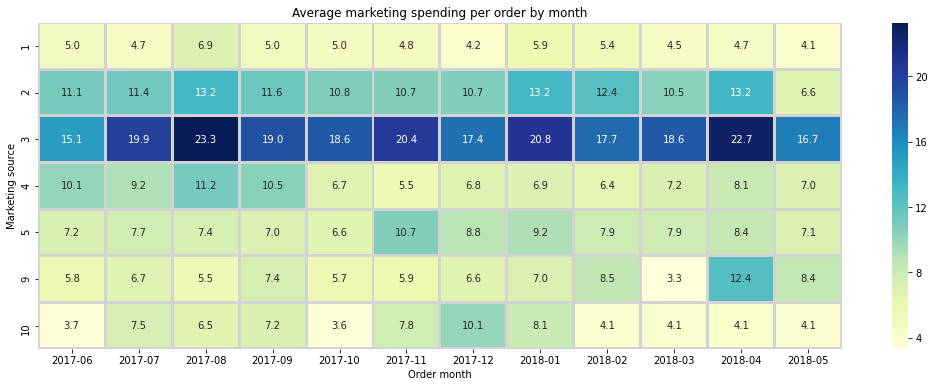

In [221]:
xlabel = "Order month"
ylabel = "Marketing source"
title = "Average marketing spending per order by month"
cohort_viz(monthly_source_cac_pivot, fmt = '.1f', title = title, xlabel = xlabel, ylabel = ylabel)

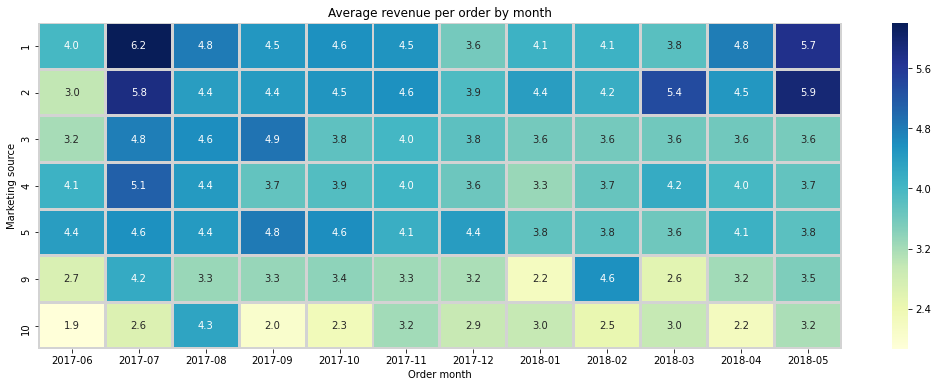

In [222]:
xlabel = "Order month"
ylabel = "Marketing source"
title = "Average revenue per order by month"
cohort_viz(monthly_source_revenue_pivot, fmt = '.1f', title = title, xlabel = xlabel, ylabel = ylabel)

The numbers look pretty disturbing: there are only three months when revenues were higher than marketing spendings and just for one marketing source, number `1`.

Let's conduct the last estimate: we will calculate the ratio between revenue and marketing costs by source and month:

In [223]:
monthly_revenue_cost_pivot = pd.DataFrame(revenue_source_report.index)
for col in revenue_source_report.columns.to_list():
    monthly_revenue_cost_pivot = monthly_revenue_cost_pivot.merge(revenue_source_report[col]/
                                                              monthly_costs_pivot[col], on = 'source_id')
monthly_revenue_cost_pivot = monthly_revenue_cost_pivot.set_index('source_id')

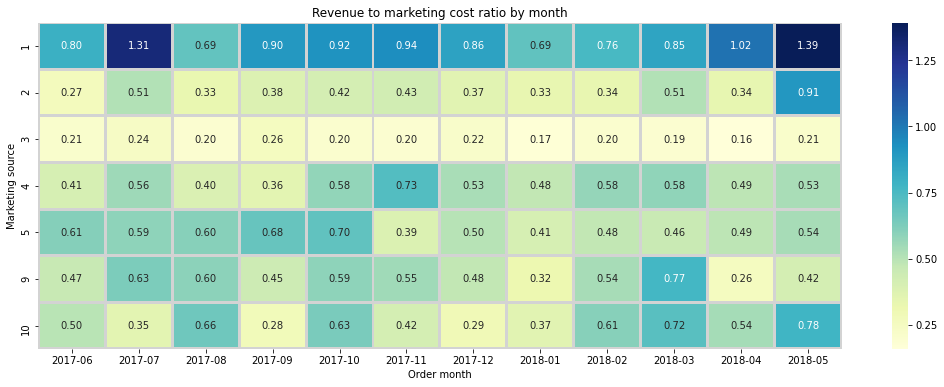

In [224]:
xlabel = "Order month"
ylabel = "Marketing source"
title = "Revenue to marketing cost ratio by month"
cohort_viz(monthly_revenue_cost_pivot, fmt = '.2f', title = title, xlabel = xlabel, ylabel = ylabel)

**One can notice, that the marketing source number `1` had been systematically the most "efficient" one. The least efficient was the marketing source number `3`, which seems to be even more disturbing since we remember that this source received more than 41% of the marketing budget, while the spendings on the source number `1` got appr. 6%. There is no specific pattern to reveal any kind of effectivenes for other marketing sources. Source `10`, while being the cheapest in terms of new buyers attraction, seems to bring buyers whose average purchase size is very small as well.**

### Summary on the marketing expenses <a id='marketing_conclusions'></a>

1. We investigated daily data for seven marketing sources. The overall marketing spending for the given period was 329131.62 units, the median daily spending across sources was 77.3 units, the maximum - 1788.3 units. More than 41% of this sum was spent on source `3`. Sources `3`, `4`, and `5` took almost 75% of the overall marketing spending for the given period.
2. The marketing spending starting from September 2017 to March 2018 were slightly higher than in other months.
3. To analyze marketing costs by sources and months, we have connected between the `uid`'s in the `orders` dataset and the `source_id` in the `costs` dataset through the `source_id` and `uid` in the `visit` dataset. Assuming that the last source before a particular order was the one that brought the buyer, we calculated the minimal time difference between the end of a session in `visits` and the order timestamp in `orders`.
4. CAC for different sources varied from 5.0 units per buyer on average for the source 1 up to 19.2 units per buyer on average for the source 3. Source 10 was the next best after 1 and source 9 took the third place. A simple linear regression model seems to be applicable in this case as well and it suggests that CAC is had been getting lower during the one-year period under consideration.
4. The overall investments in marketing were not worthwhile: the overall CAC was less than LTV only for the very first cohort, from June 2017, and for the September 2017 cohort. Following our previous observations, the buyers from the June 2017 cohort happened to be relatively loyal, while several buyers from the September 2017 cohort spent unexpectedly high amount of money on purchases in winter (chances are with no relation to the grow in the marketing spendings which took place in the following months).
5. There was not enough data to make conclusions about cohorts of 2018 and given the results with regard to LTV in general, the direct comparison between marketing costs and revenues from the orders in the given month was proposed as a way to estimate the marketing source efficiency.
6.  In addition to monthly CAC by sources, we havr derived monthly order numbers and monthly revenues for different marketing sources and compared them to the monthly spendings on the same marketing sources. Finally, we have calculated the ratio between the revenue and marketing costs by source and month.
7. The marketing source number `1` had been systematically the most "efficient" one. The least efficient one was the marketing source number `3`, which seems to be even more disturbing since we remember that this source received more than 41% of the marketing budget and was appr. 7 times more costly than `1`; the spendings on the source number `1` got appr. 6% of total costs.
8.  Sources `10`, while being the cheapest in terms of new buyers attraction, seems to bring buyers whose average purchase size is very small as well.

[Back to Content](#content)

# Conclusions <a id='conclusions'></a>

To sum up the three summary chapters (on [products](#product_conclusions), [sales](#sales_conclusions) and [marketing costs](#marketing_conclusions)), we can make the following recommendations to the team:

1. Abandon the marketing source number `3` and refocus the marketing spendings onto source number `1`, which costs 6 to 7 times less per new buyer and has much better potential to bring revenues higher than costs.
2. Investigate how the average purchase size can be boosted for buyers who come through the source number `1`.
3. Study the reasons for 50% to 80% churn in the first month following the first order to boost the retention rates.
4. Pay special attention to users using touch devices and users using both touch devices and desktops; the latter exhibited much higher retention rates.
5. Finally, additional investigation could be performed to find out why the very first cohort in the dataset remained the most loyal and apply the knowledge to nurture other cohorts.